# **Importing Libraries**


In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy.optimize import minimize
from sklearn.linear_model import LinearRegression
# from statsmodels.tsa.stattools import grangercausalitytests, adfuller
from scipy.stats import skew
from statsmodels.tsa.vector_ar.var_model import VAR
import traceback
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
from scipy.spatial.distance import squareform
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn.feature_selection import VarianceThreshold
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import shap
from pmdarima import auto_arima

# **Setting Up Data File Paths**


In [ ]:
temperature_file_path = '/content/drive/My Drive/CAN Fellowship/Datasets/Working Folder/Copy of temperature.csv'
precipitation_file_path = '/content/drive/My Drive/CAN Fellowship/Datasets/Working Folder/Copy of precipitation.csv'
locations_file_path = '/content/drive/My Drive/CAN Fellowship/Datasets/Working Folder/Copy of locations.csv'
air_quality_file_path = '/content/drive/My Drive/CAN Fellowship/Datasets/Working Folder/Copy of air_quality.csv'
sca_file_path = '/content/drive/My Drive/CAN Fellowship/Datasets/Working Folder/download.csv'

# **Data Cleaning**

## **Sickle Cell Data**

In [ ]:
sc = pd.read_csv(sca_file_path)
filtered_sc = sc[
    (sc['Location'].isin([
    'Algeria', 'Egypt', 'Libya', 'Morocco', 'Tunisia', 'Angola', 'Central African Republic', 'Congo', 'Democratic Republic of the Congo', 'Equatorial Guinea',
    'Gabon', 'Burundi', 'Comoros', 'Djibouti', 'Eritrea', 'Ethiopia', 'Kenya', 'Madagascar', 'Malawi', 'Mauritius', 'Mozambique', 'Rwanda', 'Seychelles',
    'Somalia', 'United Republic of Tanzania', 'Uganda', 'Zambia', 'Botswana', 'Lesotho', 'Namibia', 'South Africa', 'Eswatini', 'Zimbabwe', 'Benin',
    'Burkina Faso', 'Cameroon', 'Cabo Verde', 'Chad', "Côte d'Ivoire", 'Gambia', 'Ghana', 'Guinea', 'Guinea-Bissau', 'Liberia', 'Mali', 'Mauritania', 'Niger',
    'Nigeria', 'Sao Tome and Principe', 'Senegal', 'Sierra Leone', 'Togo'
]))
]
filtered_sc.drop(columns=['Measure', 'Cause of death or injury', 'Sex', 'Age'], inplace=True)
filtered_sc.head()

/tmp/ipython-input-4-1803752954.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_sc.drop(columns=['Measure', 'Cause of death or injury', 'Sex', 'Age'], inplace=True)


,Location,Year,Value,Lower bound,Upper bound
1,Angola,1990,243.838354,49.437910,519.921417
12,Burundi,1990,29.978490,16.657113,47.185788
14,Benin,1990,867.708211,357.258518,1517.447147
15,Burkina Faso,1990,1539.607385,92.013203,7211.480015
29,Botswana,1990,2.195910,1.376266,3.682299


In [ ]:
country_code_map = {
    'Algeria': 'dz', 'Egypt': 'eg', 'Libya': 'ly', 'Morocco': 'ma', 'Tunisia': 'tn',
    'Angola': 'ao', 'Central African Republic': 'cf', 'Congo': 'cg',
    'Democratic Republic of the Congo': 'cd', 'Equatorial Guinea': 'gq',
    'Gabon': 'ga', 'Burundi': 'bi', 'Comoros': 'km', 'Djibouti': 'dj',
    'Eritrea': 'er', 'Ethiopia': 'et', 'Kenya': 'ke', 'Madagascar': 'mg',
    'Malawi': 'mw', 'Mauritius': 'mu', 'Mozambique': 'mz', 'Rwanda': 'rw',
    'Seychelles': 'sc', 'Somalia': 'so', 'United Republic of Tanzania': 'tz',
    'Uganda': 'ug', 'Zambia': 'zm', 'Botswana': 'bw', 'Lesotho': 'ls',
    'Namibia': 'na', 'South Africa': 'za', 'Eswatini': 'sz', 'Zimbabwe': 'zw',
    'Benin': 'bj', 'Burkina Faso': 'bf', 'Cameroon': 'cm', 'Cabo Verde': 'cv',
    'Chad': 'td', "Côte d'Ivoire": 'ci', 'Gambia': 'gm', 'Ghana': 'gh',
    'Guinea': 'gn', 'Guinea-Bissau': 'gw', 'Liberia': 'lr', 'Mali': 'ml',
    'Mauritania': 'mr', 'Niger': 'ne', 'Nigeria': 'ng', 'Sao Tome and Principe': 'st',
    'Senegal': 'sn', 'Sierra Leone': 'sl', 'Togo': 'tg'
}

# Adding the country_code column by mapping the location_name to the country_code
filtered_sc['country_code'] = filtered_sc['Location'].map(country_code_map)

/tmp/ipython-input-5-1207165284.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_sc['country_code'] = filtered_sc['Location'].map(country_code_map)


In [ ]:
region_map = {
    'Algeria': 'North Africa',
    'Egypt': 'North Africa',
    'Libya': 'North Africa',
    'Morocco': 'North Africa',
    'Tunisia': 'North Africa',
    'Angola': 'Central Africa',
    'Central African Republic': 'Central Africa',
    'Congo': 'Central Africa',
    'Democratic Republic of the Congo': 'Central Africa',
    'Equatorial Guinea': 'Central Africa',
    'Gabon': 'Central Africa',
    'Burundi': 'East Africa',
    'Comoros': 'East Africa',
    'Djibouti': 'East Africa',
    'Eritrea': 'East Africa',
    'Ethiopia': 'East Africa',
    'Kenya': 'East Africa',
    'Madagascar': 'East Africa',
    'Malawi': 'East Africa',
    'Mauritius': 'East Africa',
    'Mozambique': 'East Africa',
    'Rwanda': 'East Africa',
    'Seychelles': 'East Africa',
    'Somalia': 'East Africa',
    'United Republic of Tanzania': 'East Africa',
    'Uganda': 'East Africa',
    'Zambia': 'East Africa',
    'Botswana': 'Southern Africa',
    'Lesotho': 'Southern Africa',
    'Namibia': 'Southern Africa',
    'South Africa': 'Southern Africa',
    'Eswatini': 'Southern Africa',
    'Zimbabwe': 'Southern Africa',
    'Benin': 'West Africa',
    'Burkina Faso': 'West Africa',
    'Cameroon': 'Central Africa',
    'Cabo Verde': 'West Africa',
    'Chad': 'Central Africa',
    "Côte d'Ivoire": 'West Africa',
    'Gambia': 'West Africa',
    'Ghana': 'West Africa',
    'Guinea': 'West Africa',
    'Guinea-Bissau': 'West Africa',
    'Liberia': 'West Africa',
    'Mali': 'West Africa',
    'Mauritania': 'West Africa',
    'Niger': 'West Africa',
    'Nigeria': 'West Africa',
    'Sao Tome and Principe': 'Central Africa',
    'Senegal': 'West Africa',
    'Sierra Leone': 'West Africa',
    'Togo': 'West Africa'
}


# Adding the region column by mapping the location_name to the region
filtered_sc['region'] = filtered_sc['Location'].map(region_map)


/tmp/ipython-input-6-797654576.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_sc['region'] = filtered_sc['Location'].map(region_map)


## **Climate Locations**

In [ ]:
locations = pd.read_csv(locations_file_path)
locations.head()

,latitude,longitude,location,country_code,state,region,county,city,town,village,hamlet
0,14.5,-17.5,Sénégal,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,28.5,-17.5,España,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,11.5,-16.5,"{'country': 'Guinea-Bissau', 'country_code': '...",gw,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,12.5,-16.5,"{'city': ""Communauté rurale d'Oukout"", 'munici...",sn,NaN,Région de Ziguinchor,NaN,Communauté rurale d'Oukout,NaN,Djivente,NaN
4,13.5,-16.5,"{'county': 'Lower Niumi', 'state_district': 'K...",gm,North Bank,NaN,Lower Niumi,NaN,Barra,NaN,NaN


In [ ]:
# List of country codes to filter
country_codes = [
    'dz', 'eg', 'ly', 'ma', 'tn', 'ao', 'cf', 'cg', 'cd', 'gq', 'ga', 'bi', 'km', 'dj', 'er', 'et', 'ke',
    'mg', 'mw', 'mu', 'mz', 'rw', 'sc', 'so', 'tz', 'ug', 'zm', 'bw', 'ls', 'na', 'za', 'sz', 'zw', 'bj',
    'bf', 'cm', 'cv', 'td', 'ci', 'gm', 'gh', 'gn', 'gw', 'lr', 'ml', 'mr', 'ne', 'ng', 'st', 'sn', 'sl', 'tg'
]

# Selecting latitude, longitude, and country_code, and filter rows where country_code is in the specified list
filtered_locations = locations[['latitude', 'longitude', 'country_code']]

# Filtering rows based on country_code being in the list
filtered_locations = filtered_locations[filtered_locations['country_code'].isin(country_codes)]


In [ ]:
filtered_locations = filtered_locations.drop_duplicates()

## **Temperature Data**

In [ ]:
temperature = pd.read_csv(temperature_file_path)

In [ ]:
# Adding the country_code column by merging with filtered_locations on latitude and longitude
temperature = temperature.merge(filtered_locations[['latitude', 'longitude', 'country_code']],
                                on=['latitude', 'longitude'],
                                how='left')

# Dropping rows where country_code is null
temperature.dropna(subset=['country_code'], inplace=True)

# Dropping rows where the year is not found in the distinct year_ids of the filtered_sc dataframe
valid_years = filtered_sc['Year'].unique()
temperature = temperature[temperature['year'].isin(valid_years)]


In [ ]:
# Grouping by year and country_code and applying the aggregation functions
temperature_grouped = temperature.groupby(['country_code', 'year', 'month_number']).agg(
    tmin_temperature=('tmin_temperature', 'min'),
    tmax_temperature=('tmax_temperature', 'max'),
    tavg_temperature=('tavg_temperature', 'mean'),
    tmed_temperature=('tavg_temperature', 'median')
).reset_index()


## **Precipitation Data**

In [ ]:
precipitation = pd.read_csv(precipitation_file_path)

In [ ]:
# Adding the country_code column by merging with filtered_locations on latitude and longitude
precipitation = precipitation.merge(filtered_locations[['latitude', 'longitude', 'country_code']],
                                on=['latitude', 'longitude'],
                                how='left')

# Dropping rows where country_code is null
precipitation.dropna(subset=['country_code'], inplace=True)

# Dropping rows where the year is not found in the distinct year_ids of the filtered_sc dataframe
valid_years = filtered_sc['Year'].unique()
precipitation = precipitation[precipitation['year'].isin(valid_years)]

In [ ]:
# Summing precipitation per (lat, lon) location, per year, month and country
location_totals = precipitation.groupby(['country_code', 'latitude', 'longitude', 'year', 'month_number'])['precip'].sum().reset_index(name='location_total_precip')

# Aggregating statistics at the country level
precipitation_grouped = location_totals.groupby(['country_code', 'year', 'month_number']).agg(
    min_precipitation=('location_total_precip', 'min'),
    max_precipitation=('location_total_precip', 'max'),
    avg_precipitation=('location_total_precip', 'mean'),
    med_precipitation=('location_total_precip', 'median')
).reset_index()

## **Aerosol Optical Depth Data (Particulate Matter Indicator)**

In [ ]:
air_quality = pd.read_csv(air_quality_file_path)

In [ ]:
air_quality.dropna(inplace=True)

In [ ]:
# Adding the country_code column by merging with filtered_locations on latitude and longitude
air_quality = air_quality.merge(filtered_locations[['latitude', 'longitude', 'country_code']],
                                on=['latitude', 'longitude'],
                                how='left')

# Dropping rows where country_code is null
air_quality.dropna(subset=['country_code'], inplace=True)

# Dropping rows where the year is not found in the distinct year_ids of the filtered_sc dataframe
valid_years = filtered_sc['Year'].unique()
air_quality = air_quality[air_quality['year'].isin(valid_years)]

In [ ]:
# Grouping by year, month and country_code and applying the aggregation functions
air_quality_grouped = air_quality.groupby(['country_code', 'year', 'month_number']).agg(
    min_aod=('aod_min', 'min'),
    max_aod=('aod_max', 'max'),
    avg_aod=('aod_mean', 'mean'),
    med_aod=('aod_mean', 'median')
).reset_index()

# **Merging Datasets**

In [ ]:
# Merging the climate datasets
# Merging temperature and precipitation datasets based on country_code, month and year

climate_data = pd.merge(temperature_grouped[['country_code', 'year', 'month_number', 'tavg_temperature', 'tmed_temperature', 'tmin_temperature', 'tmax_temperature']],
                        precipitation_grouped[['country_code', 'year', 'month_number', 'avg_precipitation', 'med_precipitation', 'min_precipitation', 'max_precipitation']],
                        on=['country_code', 'year', 'month_number'], how='inner')

# Merging air quality data
climate_data = pd.merge(climate_data, air_quality_grouped[['country_code', 'year', 'month_number', 'avg_aod', 'med_aod', 'min_aod', 'max_aod']],
                        on=['country_code', 'year', 'month_number'], how='left')

In [ ]:
# yearly data to aid weighted augmentation
yearly_climate_data = climate_data.groupby(['country_code', 'year']).agg(
    yearly_avg_temperature=('tavg_temperature', 'mean'),
    yearly_avg_precipitation=('avg_precipitation', 'sum')
).reset_index()

In [ ]:
# Merging yearly climate data with sickle cell mortality data
yearly_data = pd.merge(yearly_climate_data, filtered_sc[['country_code', 'Year', 'region', 'Location','Value']], left_on=['country_code', 'year'], right_on=['country_code', 'Year'], how='left')
yearly_data.drop('Year', axis=1, inplace=True)


In [ ]:
# Merging all data
final_data = pd.merge(climate_data, yearly_data, on=['country_code', 'year'], how='inner')

# **Data Augmentation**

In [ ]:
# Denton-Cholette–Style Disaggregation

def denton_disaggregate(yearly_total, indicator_series, smooth_order=2):
    indicators = np.maximum(indicator_series, 0.01)
    indicators = indicators / indicators.sum()
    initial = yearly_total * indicators

    def objective(x):
        return np.sum(np.diff(x, n=smooth_order) ** 2)

    constraints = [{'type': 'eq', 'fun': lambda x: np.sum(x) - yearly_total}]
    bounds = [(0, None)] * 12

    res = minimize(objective, initial, method='SLSQP', bounds=bounds, constraints=constraints)

    if not res.success:
        return np.round(initial).astype(int)

    raw = res.x
    floored = np.floor(raw).astype(int)
    diff = int(round(yearly_total)) - floored.sum()

    if diff > 0:
        for i in np.argsort(raw - floored)[-diff:]:
            floored[i] += 1
    elif diff < 0:
        for i in np.argsort(floored - raw)[:abs(diff)]:
            floored[i] -= 1

    return np.maximum(floored, 0)


In [ ]:
# Estimating country-specific weights
def get_country_climate_weights(final_data, Value):
    weights = {}
    features = ['yearly_avg_temperature', 'yearly_avg_precipitation']

    for country, group in final_data.groupby('country_code'):
        group_yearly = group.drop_duplicates(subset='year')
        if len(group_yearly) < 2:
            continue

        X = group_yearly[features].values
        y = group_yearly[Value].values

        if np.all(np.isnan(y)) or np.all(y == y[0]):
            continue

        model = LinearRegression().fit(X, y)
        weights[country] = tuple(model.coef_)

    return weights

In [ ]:
# Applying Denton disaggregation
def disaggregate_monthly(final_data, Value, weights_by_country):
    output_col = f'monthly_{Value}'
    final_data[output_col] = np.nan

    for (country, year), group in final_data.groupby(['country_code', 'year']):
        if len(group) != 12 or pd.isna(group[Value].iloc[0]):
            continue

        temp = group['tavg_temperature'].values
        precip = group['avg_precipitation'].values
        weights = weights_by_country.get(country, (0.5, 0.5))

        indicators = weights[0] * temp + weights[1] * precip
        monthly = denton_disaggregate(group[Value].iloc[0], indicators)

        final_data.loc[group.index, output_col] = monthly

    final_data[output_col] = final_data[output_col].astype("Int64")
    return final_data

In [ ]:
final_aug_data = disaggregate_monthly(final_data, 'Value', get_country_climate_weights(final_data, 'Value'))

In [ ]:
# imputation for missing mortality values
def impute_monthly_mortality(df, monthly_col, yearly_col):
    df = df.copy()

    for (country, year), group in df.groupby(["country_code", "year"]):
        if pd.isna(year) or pd.isna(country):
            continue

        yearly_total = group[yearly_col].iloc[0]
        if pd.isna(yearly_total):
            continue

        indices = group.index
        monthly_vals = df.loc[indices, monthly_col].values

        known_mask = ~pd.isna(monthly_vals)
        known_sum = round(monthly_vals[known_mask].sum()) if known_mask.any() else 0
        count_known = known_mask.sum()
        missing_mask = pd.isna(monthly_vals)
        count_missing = 12 - count_known

        # Handle edge case: more than 12 or fewer than 12 months in data
        if count_missing <= 0:
            df.loc[indices[missing_mask], monthly_col] = 0
            continue

        if known_sum >= round(yearly_total):
            df.loc[indices[missing_mask], monthly_col] = 0
        else:
            residual = round(yearly_total) - known_sum
            per_month_value = round(residual / count_missing)
            df.loc[indices[missing_mask], monthly_col] = per_month_value

    df[monthly_col] = df[monthly_col].astype("Int64")
    return df

final_filled_data = impute_monthly_mortality(final_aug_data, 'monthly_Value', 'Value')

In [ ]:
# imputation for missing temperature min and max values
final_filled_data.loc[final_filled_data['tmin_temperature'].isna(), 'tmin_temperature'] = np.minimum(final_filled_data['tmed_temperature'], final_filled_data['tavg_temperature'])
final_filled_data.loc[final_filled_data['tmax_temperature'].isna(), 'tmax_temperature'] = np.maximum(final_filled_data['tmed_temperature'], final_filled_data['tavg_temperature'])
final_filled_data = final_filled_data[final_filled_data['year'] != 2025]

# **Save Final Dataset**

In [ ]:
# # Saving to Excel
# output_path = '/content/drive/My Drive/CAN Fellowship/Datasets/Working Folder/final_augmented_data.xlsx'
# final_filled_data.to_excel(output_path, index=False)

# **Feature Generation**

In [47]:
output_path = '/content/drive/My Drive/CAN Fellowship/Datasets/Working Folder/final_augmented_data.xlsx'
df = pd.read_excel(output_path)
# df = final_filled_data

# dropping yearly values
df = df.drop(columns=['Value', 'yearly_avg_temperature', 'yearly_avg_precipitation'])
df.rename(columns={'monthly_Value': 'Value'}, inplace=True)

In [48]:
#round death values
df['Value'] = df['Value'].round(0).clip(lower=0)

In [49]:
#Composite features
# Range-based interaction terms
df['temp_range'] = df['tmax_temperature'] - df['tmin_temperature']
df['precip_range'] = df['max_precipitation'] - df['min_precipitation']
df['aod_range'] = df['max_aod'] - df['min_aod']

# Interaction terms
df['aridity_index'] = df['avg_precipitation']//(df['tavg_temperature'] + 10) # De Martonne aridity index

In [50]:
# Skewness Evaluation
dfX = df

# Identifying mean vs median feature columns
mean_cols = [col for col in dfX.columns if 'avg_' in col]
median_cols = [col for col in dfX.columns if 'med_' in col]

# Filtering only numeric columns to avoid dtype issues
mean_cols = [col for col in mean_cols if pd.api.types.is_numeric_dtype(dfX[col])]
median_cols = [col for col in median_cols if pd.api.types.is_numeric_dtype(dfX[col])]

# Evaluating skewness for each pair
results = []
for mean_col in mean_cols:
    # Infer corresponding median col
    med_col = mean_col.replace('avg_', 'med_')
    if med_col in median_cols:
        mean_skew = skew(dfX[mean_col].dropna())
        med_skew = skew(dfX[med_col].dropna())
        decision = 'drop_median' if abs(mean_skew) < abs(med_skew) else 'drop_mean'
        results.append({
            'feature_pair': (mean_col, med_col),
            'mean_skew': mean_skew,
            'median_skew': med_skew,
            'drop': decision
        })

# Creating DataFrame with results
skewness_dfX = pd.DataFrame(results)
skewness_dfX = skewness_dfX.sort_values(by='drop')

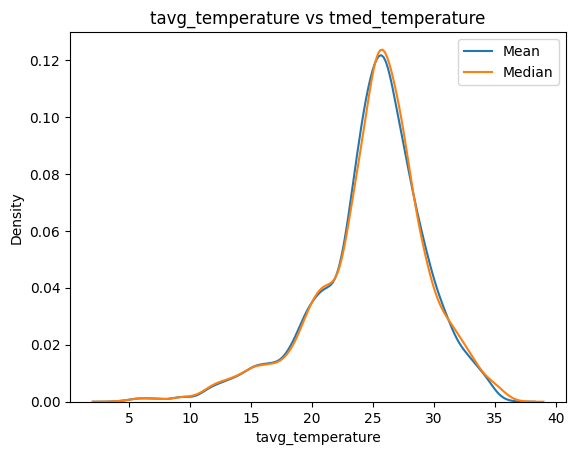

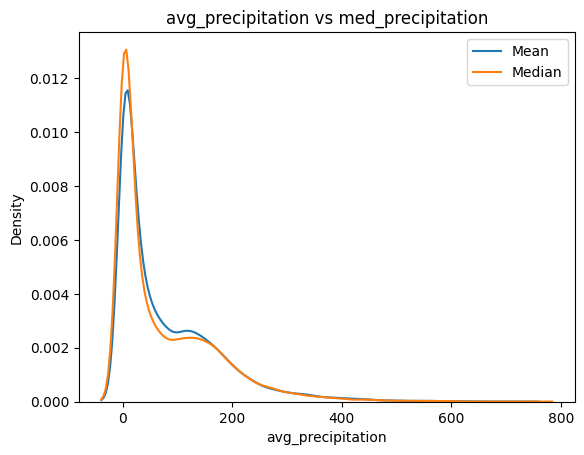

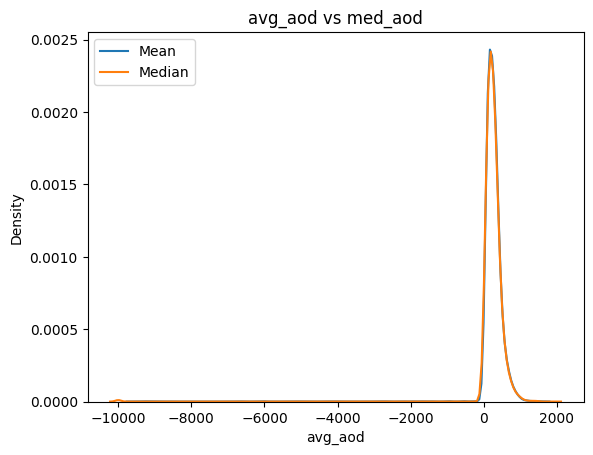

,feature_pair,mean_skew,median_skew,drop
0,"(tavg_temperature, tmed_temperature)",-0.841038,-0.804881,drop_mean
1,"(avg_precipitation, med_precipitation)",1.676228,1.673084,drop_mean
2,"(avg_aod, med_aod)",-14.449885,-17.925868,drop_median


In [51]:
# Visualising results of Fisher-Pearson coefficient of skewness.
for row in results:
    sns.kdeplot(dfX[row['feature_pair'][0]].dropna(), label='Mean')
    sns.kdeplot(dfX[row['feature_pair'][1]].dropna(), label='Median')
    plt.title(f"{row['feature_pair'][0]} vs {row['feature_pair'][1]}")
    plt.legend()
    plt.show()

skewness_dfX

In [52]:
# Dropping columns with higher absolute skew toward better stability for modeling.
df = df.drop(columns=['tavg_temperature', 'avg_precipitation', 'med_aod'])

In [53]:
# Dropping columns based on results from granger causality testing
df = df.drop(columns=['min_aod', 'avg_aod', 'aod_range'])

In [54]:
# Adding lag features and rolling average features to capture delayed health effects of climate stressors.

# Ensuring correct sort order
df = df.sort_values(['Location', 'year', 'month_number']).reset_index(drop=True)

# Variables
all_vars = ['tmin_temperature', 'precip_range', 'temp_range',
 'max_aod', 'max_precipitation', 'tmed_temperature',
 'aridity_index', 'med_precipitation',
 'tmax_temperature', 'min_precipitation'
]

# Lags (in months)
lags = [1, 3]

# Rolling windows (in months)
windows = [3, 6]

# LAG FEATURES
for var in all_vars:
    for lag in lags:
        df[f'{var}_lag{lag}'] = df.groupby('Location')[var].shift(lag)

# ROLLING FEATURES (trailing only)
for var in all_vars:
    for window in windows:
        df[f'{var}_roll{window}'] = (
            df.groupby('Location')[var]
              .shift(1)  # excluding current month to prevent leakage
              .rolling(window=window, min_periods=1)
              .mean()
              .reset_index(level=0, drop=True)
        )

In [55]:
# Encoding cyclicality and indicating that December and January are adjacent
df['month_sin'] = np.sin(2 * np.pi * df['month_number'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month_number'] / 12)
final_df = df.copy().reset_index(drop=True)

# **Region Specific Model for Central Africa**

##**Feature Selection**

In [77]:
df = final_df[final_df['region'] == 'Central Africa'].copy().reset_index(drop=True)
exclude_cols = ['Value', 'year', 'month_number', 'Location', 'region', 'country_code']
numeric_cols = df.select_dtypes(include='number').columns
feature_cols = [col for col in numeric_cols if col not in exclude_cols]

# Feature Importance
df_model = df.copy()
X = df_model[feature_cols]
y = df_model['Value']
xgb_model = xgb.XGBRegressor(n_estimators=100, random_state=42)
xgb_model.fit(X, y)
importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance': xgb_model.feature_importances_
}).sort_values(by='importance', ascending=False)
top_features = importance_df.sort_values(by="importance", ascending=False)

In [78]:
# Computing correlation matrix
corr = df[feature_cols].corr().abs()

# Converting to distance matrix (1 - abs(correlation))
distance_matrix = 1 - corr

# Hierarchical clustering
linkage_matrix = linkage(squareform(distance_matrix), method='average')

# Assigning features to clusters
cluster_labels = fcluster(linkage_matrix, t=0.2, criterion='distance')
cluster_df = pd.DataFrame({'feature': corr.columns, 'cluster': cluster_labels})


# Merging cluster data with feature importance scores for final feature selection
features = pd.merge(cluster_df, top_features, on=['feature'], how='inner')

# Ranking within each cluster by descending importance
features['rank'] = features.groupby('cluster')['importance'] \
                           .rank(method='first', ascending=False)

features['selected'] = np.where(
    (features['rank'] == 1) & (features['importance'] > 0),
    'Select',
    ''
)

features = features.sort_values(by=["cluster", "importance"], ascending=[True, False]).reset_index(drop=True)
features['importance']= features['importance'].round(4)
features

,feature,cluster,importance,rank,selected
0,tmed_temperature,1,0.0015,1.0,Select
1,tmax_temperature,2,0.0003,1.0,Select
2,tmax_temperature_roll6,3,0.0010,1.0,Select
3,tmax_temperature_lag3,3,0.0003,2.0,
4,tmax_temperature_lag1,4,0.0009,1.0,Select
5,tmax_temperature_roll3,4,0.0008,2.0,
6,tmed_temperature_roll6,5,0.0004,1.0,Select
7,tmed_temperature_lag3,5,0.0002,2.0,
8,tmed_temperature_roll3,6,0.0008,1.0,Select
9,tmed_temperature_lag1,6,0.0004,2.0,


In [79]:
low_importance_collinear_features = features[features['selected'] != "Select"]['feature'].tolist()
# low_importance_collinear_features
df = df.drop(columns=low_importance_collinear_features)

In [80]:
# Features
exclude_cols = ['Value', 'year', 'month_number', 'Location', 'region', 'country_code']
numeric_cols = df.select_dtypes(include='number').columns
feature_cols = [col for col in numeric_cols if col not in exclude_cols]


# Group-based interpolation and fallback to global mean
df_imputed = df.copy()

# Applying backward fill to columns with little missing data
columns_to_bfill = df.columns[(df.isna().sum() >= 1) & (df.isna().sum() <= 49)]

df_imputed[columns_to_bfill] = (
    df.groupby('Location')[columns_to_bfill]
    .transform(lambda group: group.bfill())
)

# Interpolating missing values within each country
df_imputed[feature_cols] = (
    df.groupby('Location')[feature_cols]
    .transform(lambda group: group.fillna(group.mean()))
)

# Fallback: filling remaining NaNs with region-wise median
df_imputed[feature_cols] = (
    df_imputed
    .groupby('region')[feature_cols]
    .transform(lambda group: group.fillna(group.median()))
)

# Final fallback: fill any still-missing values with global column median
df_imputed[feature_cols] = df_imputed[feature_cols].fillna(df_imputed[feature_cols].median())

In [81]:
# VIF
X = df_imputed[feature_cols]
constant_filter = VarianceThreshold(threshold=0.0)
X = X.loc[:, constant_filter.fit(X).get_support()]
X = add_constant(X)
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                   for i in range(X.shape[1])]
vif_data = vif_data[vif_data["feature"] != "const"]

# Merging both
features = pd.merge(vif_data, features[['feature', 'importance']], on=['feature'], how='left')
features = features.sort_values(by='importance', ascending=False)
features.reset_index(drop=True)

/usr/local/lib/python3.11/dist-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


,feature,VIF,importance
0,max_precipitation_roll6,inf,0.4587
1,tmin_temperature_roll6,inf,0.3996
2,temp_range_roll6,inf,0.0616
3,max_aod_lag3,3.922701,0.0234
4,precip_range_lag1,9.647081,0.0037
5,max_aod_roll3,9.116844,0.0018
6,month_cos,1.595631,0.0017
7,tmed_temperature,6.706330,0.0015
8,max_aod,1.502183,0.0015
9,precip_range_roll6,inf,0.0012


In [82]:
high_VIF_features = features[features['VIF'] > 7]['feature'].tolist()
# high_VIF_features
df = df.drop(columns=high_VIF_features)

## **Selected Features**

In [83]:
# Features
exclude_cols = ['Value', 'year', 'month_number', 'Location', 'region', 'country_code']
numeric_cols = df.select_dtypes(include='number').columns
feature_cols = [col for col in numeric_cols if col not in exclude_cols]

# Feature Importance
df_model = df.copy()
X = df_model[feature_cols]
y = df_model['Value']
xgb_model = xgb.XGBRegressor(n_estimators=100, random_state=42)
xgb_model.fit(X, y)
importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance': xgb_model.feature_importances_
}).sort_values(by='importance', ascending=False)
top_features = importance_df.sort_values(by="importance", ascending=False)


# VIF
X = df_imputed[feature_cols]
constant_filter = VarianceThreshold(threshold=0.0)
X = X.loc[:, constant_filter.fit(X).get_support()]
X = add_constant(X)
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                   for i in range(X.shape[1])]
vif_data = vif_data[vif_data["feature"] != "const"]

# Merging both
features = pd.merge(top_features, vif_data, on=['feature'], how='inner')
features = features.sort_values(by='importance', ascending=False).reset_index(drop=True)
features


,feature,importance,VIF
0,max_aod_roll6,0.158982,2.517221
1,month_sin,0.142061,1.112791
2,month_cos,0.136439,1.103090
3,min_precipitation,0.126271,1.662447
4,max_precipitation,0.115488,1.710543
5,max_aod,0.103321,1.374117
6,tmed_temperature,0.099365,1.087981
7,max_aod_lag1,0.062805,1.570622
8,max_aod_lag3,0.055268,1.796249


##**Modeling**

In [84]:
# XGBoost Model

X = df[feature_cols]
y = df['Value']  # mortality

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Training XGBoost

# Initial model
# model = xgb.XGBRegressor(
#     n_estimators=100,
#     learning_rate=0.1,
#     max_depth=4,
#     random_state=42
# )
# model.fit(X_train, y_train)

# Optimized model
model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=1000, # More trees to allow learning more complex patterns
    early_stopping_rounds=50, # adding stop if no improvement in 50 rounds to prevent long training & avoid overfitting
    eval_metric='rmse',
    learning_rate=0.05, #Lower learning rate for better generalization
    max_depth=6, #Deeper trees to model interactions better
    subsample=0.8, #Introducing row sampling for regularization to reduce overfitting
    colsample_bytree=0.8, # including feature sampling per tree to improve generalization
    random_state=42
)


# Fitting with eval set
model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    verbose=False
)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [85]:
# Access best iteration and score
print(f"Best iteration: {model.best_iteration}")
print(f"Best score on validation set: {model.best_score}")

# Make predictions using the best model
predictions = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f"RMSE on validation set using best model: {rmse}")

Best iteration: 388
Best score on validation set: 32.4288351085836
RMSE on validation set using best model: 32.428835849152065


In [86]:
# Regression Metrics

y_pred = model.predict(X_test)
y_pred = np.round(np.clip(y_pred, 0, None),0)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R²: {r2:.3f}")
print(f"MAPE: {mape:.2f}")


RMSE: 32.33
MAE: 17.38
R²: 0.686


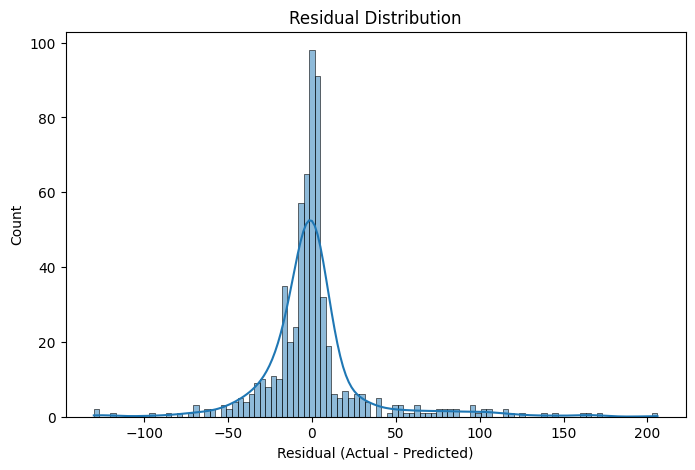

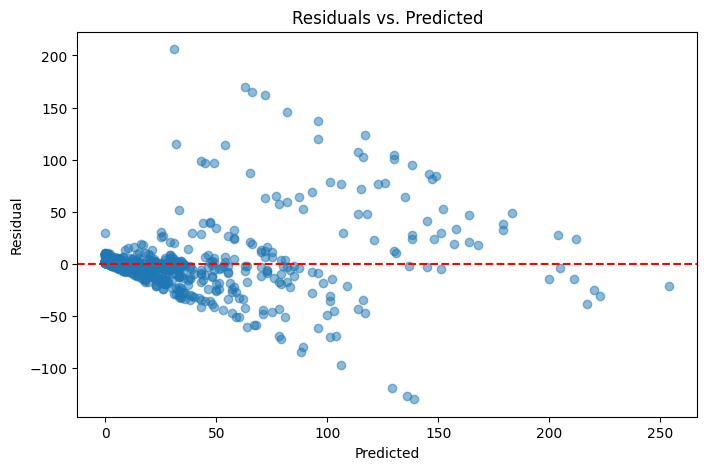

In [87]:
# Residual Analysis:
import matplotlib.pyplot as plt
import seaborn as sns

residuals = y_test - y_pred

plt.figure(figsize=(8, 5))
sns.histplot(residuals, kde=True)
plt.title("Residual Distribution")
plt.xlabel("Residual (Actual - Predicted)")
plt.show()

# Residuals vs predicted
plt.figure(figsize=(8, 5))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residuals vs. Predicted")
plt.xlabel("Predicted")
plt.ylabel("Residual")
plt.show()


In [88]:
#For Explainability
# Extracting SHAP Values
# SHAP explainer
explainer = shap.TreeExplainer(model)
shap_values = explainer(X)  # SHAP values for all rows

In [89]:
# Converting SHAP Values to DataFrame
shap_df = pd.DataFrame(shap_values.values, columns=X.columns) #columns=feature_cols
shap_df["model_output"] = shap_values.values.sum(axis=1) + shap_values.base_values #actual model output (the model’s prediction output for X)
shap_df["base_value"] = shap_values.base_values #the baseline prediction (base_value)
shap_df['region'] = df['region']
shap_df['country_code'] = df['country_code']
shap_df['Location'] = df['Location']
shap_df['year'] = df['year']
shap_df['month_number'] = df['month_number']
shap_df['Value'] = df['Value']

In [90]:
# Normalizing SHAP Scores (Climate Impact Weights)
# Computing absolute shap values per row
abs_shap = shap_df[feature_cols].abs()

# Normalizing by row total to get % contribution
norm_shap = abs_shap.div(abs_shap.sum(axis=1), axis=0)
norm_shap.columns = [col + '_weight' for col in norm_shap.columns]

# Combining with original data
impact_df = pd.concat([df[['region', 'country_code', 'Location', 'year', 'month_number', 'Value']], norm_shap], axis=1)

# Adding a “climate impact score” (magnitude of all SHAP)
impact_df['climate_score'] = shap_df[feature_cols].sum(axis=1)
impact_df['climate_score']  = np.round(np.clip(impact_df['climate_score'] , 0, None),0)

In [91]:
columns_to_keep = ['region', 'country_code', 'Location', 'year', 'month_number', 'Value', 'climate_score']
Central_Africa = impact_df[columns_to_keep].copy()

# **Region Specific Model for East Africa**

##**Feature Selection**

In [96]:
df = final_df[final_df['region'] == 'East Africa'].copy().reset_index(drop=True)
exclude_cols = ['Value', 'year', 'month_number', 'Location', 'region', 'country_code']
numeric_cols = df.select_dtypes(include='number').columns
feature_cols = [col for col in numeric_cols if col not in exclude_cols]

# Feature Importance
df_model = df.copy()
X = df_model[feature_cols]
y = df_model['Value']
xgb_model = xgb.XGBRegressor(n_estimators=100, random_state=42)
xgb_model.fit(X, y)
importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance': xgb_model.feature_importances_
}).sort_values(by='importance', ascending=False)
top_features = importance_df.sort_values(by="importance", ascending=False)

In [97]:
# Computing correlation matrix
corr = df[feature_cols].corr().abs()

# Converting to distance matrix (1 - abs(correlation))
distance_matrix = 1 - corr

# Hierarchical clustering
linkage_matrix = linkage(squareform(distance_matrix), method='average')

# Assigning features to clusters
cluster_labels = fcluster(linkage_matrix, t=0.2, criterion='distance')
cluster_df = pd.DataFrame({'feature': corr.columns, 'cluster': cluster_labels})


# Merging cluster data with feature importance scores for final feature selection
features = pd.merge(cluster_df, top_features, on=['feature'], how='inner')

# Ranking within each cluster by descending importance
features['rank'] = features.groupby('cluster')['importance'] \
                           .rank(method='first', ascending=False)

features['selected'] = np.where(
    (features['rank'] == 1) & (features['importance'] > 0),
    'Select',
    ''
)

features = features.sort_values(by=["cluster", "importance"], ascending=[True, False]).reset_index(drop=True)
features['importance']= features['importance'].round(4)
features

,feature,cluster,importance,rank,selected
0,tmax_temperature_roll6,1,0.1928,1.0,Select
1,tmax_temperature_lag1,1,0.0067,2.0,
2,tmax_temperature_roll3,1,0.0046,3.0,
3,tmax_temperature,1,0.0033,4.0,
4,tmax_temperature_lag3,1,0.0007,5.0,
5,tmed_temperature_roll6,2,0.0773,1.0,Select
6,tmed_temperature,2,0.0116,2.0,
7,tmed_temperature_lag3,2,0.0082,3.0,
8,tmed_temperature_lag1,2,0.0061,4.0,
9,tmed_temperature_roll3,2,0.0058,5.0,


In [98]:
low_importance_collinear_features = features[features['selected'] != "Select"]['feature'].tolist()
# low_importance_collinear_features
df = df.drop(columns=low_importance_collinear_features)

In [99]:
# Features
exclude_cols = ['Value', 'year', 'month_number', 'Location', 'region', 'country_code']
numeric_cols = df.select_dtypes(include='number').columns
feature_cols = [col for col in numeric_cols if col not in exclude_cols]


# Group-based interpolation and fallback to global mean
df_imputed = df.copy()

# Applying backward fill to columns with little missing data
columns_to_bfill = df.columns[(df.isna().sum() >= 1) & (df.isna().sum() <= 49)]

df_imputed[columns_to_bfill] = (
    df.groupby('Location')[columns_to_bfill]
    .transform(lambda group: group.bfill())
)

# Interpolating missing values within each country
df_imputed[feature_cols] = (
    df.groupby('Location')[feature_cols]
    .transform(lambda group: group.fillna(group.mean()))
)

# Fallback: filling remaining NaNs with region-wise median
df_imputed[feature_cols] = (
    df_imputed
    .groupby('region')[feature_cols]
    .transform(lambda group: group.fillna(group.median()))
)

# Final fallback: fill any still-missing values with global column median
df_imputed[feature_cols] = df_imputed[feature_cols].fillna(df_imputed[feature_cols].median())

In [100]:
# VIF
X = df_imputed[feature_cols]
constant_filter = VarianceThreshold(threshold=0.0)
X = X.loc[:, constant_filter.fit(X).get_support()]
X = add_constant(X)
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                   for i in range(X.shape[1])]
vif_data = vif_data[vif_data["feature"] != "const"]

# Merging both
features = pd.merge(vif_data, features[['feature', 'importance']], on=['feature'], how='left')
features = features.sort_values(by='importance', ascending=False)
features.reset_index(drop=True)

/usr/local/lib/python3.11/dist-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


,feature,VIF,importance
0,tmax_temperature_roll6,inf,0.1928
1,temp_range_roll6,inf,0.1824
2,precip_range_roll6,18.419557,0.1591
3,max_aod_roll6,4.261703,0.1078
4,tmed_temperature_roll6,10.729235,0.0773
5,tmin_temperature_roll6,inf,0.0215
6,min_precipitation_roll6,16.489614,0.0119
7,precip_range_roll3,12.098522,0.0103
8,precip_range,6.255102,0.0083
9,min_precipitation,9.574029,0.0068


In [101]:
high_VIF_features = features[features['VIF'] > 7]['feature'].tolist()
# high_VIF_features
df = df.drop(columns=high_VIF_features)

## **Selected Features**

In [102]:
# Features
exclude_cols = ['Value', 'year', 'month_number', 'Location', 'region', 'country_code']
numeric_cols = df.select_dtypes(include='number').columns
feature_cols = [col for col in numeric_cols if col not in exclude_cols]

# Feature Importance
df_model = df.copy()
X = df_model[feature_cols]
y = df_model['Value']
xgb_model = xgb.XGBRegressor(n_estimators=100, random_state=42)
xgb_model.fit(X, y)
importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance': xgb_model.feature_importances_
}).sort_values(by='importance', ascending=False)
top_features = importance_df.sort_values(by="importance", ascending=False)


# VIF
X = df_imputed[feature_cols]
constant_filter = VarianceThreshold(threshold=0.0)
X = X.loc[:, constant_filter.fit(X).get_support()]
X = add_constant(X)
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                   for i in range(X.shape[1])]
vif_data = vif_data[vif_data["feature"] != "const"]

# Merging both
features = pd.merge(top_features, vif_data, on=['feature'], how='inner')
features = features.sort_values(by='importance', ascending=False).reset_index(drop=True)
features


,feature,importance,VIF
0,max_aod_roll6,0.190442,3.681878
1,month_sin,0.182621,1.285127
2,precip_range,0.170710,1.130144
3,month_cos,0.167585,1.081619
4,min_precipitation_lag1,0.098978,1.341208
5,max_aod,0.068326,1.730209
6,max_aod_lag1,0.061281,2.293657
7,max_aod_lag3,0.060057,2.574553


##**Modeling**

In [103]:
# XGBoost Model

X = df[feature_cols]
y = df['Value']  # mortality

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Training XGBoost

# Initial model
# model = xgb.XGBRegressor(
#     n_estimators=100,
#     learning_rate=0.1,
#     max_depth=4,
#     random_state=42
# )
# model.fit(X_train, y_train)

# Optimized model
model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=1000, # More trees to allow learning more complex patterns
    early_stopping_rounds=50, # adding stop if no improvement in 50 rounds to prevent long training & avoid overfitting
    eval_metric='rmse',
    learning_rate=0.05, #Lower learning rate for better generalization
    max_depth=6, #Deeper trees to model interactions better
    subsample=0.8, #Introducing row sampling for regularization to reduce overfitting
    colsample_bytree=0.8, # including feature sampling per tree to improve generalization
    random_state=42
)


# Fitting with eval set
model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    verbose=False
)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [104]:
# Access best iteration and score
print(f"Best iteration: {model.best_iteration}")
print(f"Best score on validation set: {model.best_score}")

# Make predictions using the best model
predictions = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f"RMSE on validation set using best model: {rmse}")

Best iteration: 165
Best score on validation set: 10.920452513463342
RMSE on validation set using best model: 10.92045232541671


In [105]:
# Regression Metrics

y_pred = model.predict(X_test)
y_pred = np.round(np.clip(y_pred, 0, None),0)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R²: {r2:.3f}")
print(f"MAPE: {mape:.2f}")

RMSE: 10.91
MAE: 6.17
R²: 0.503


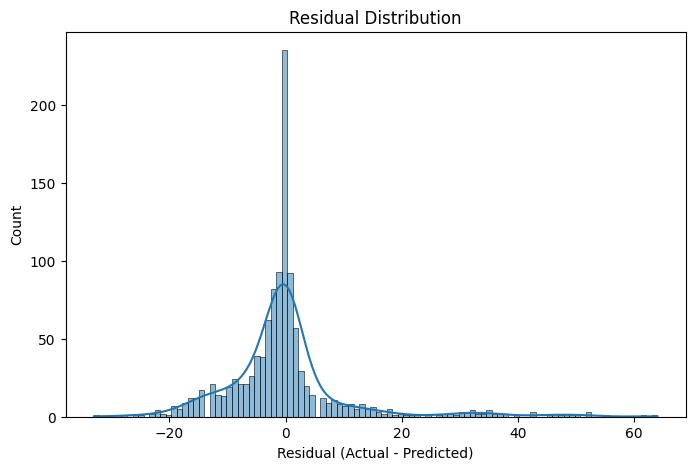

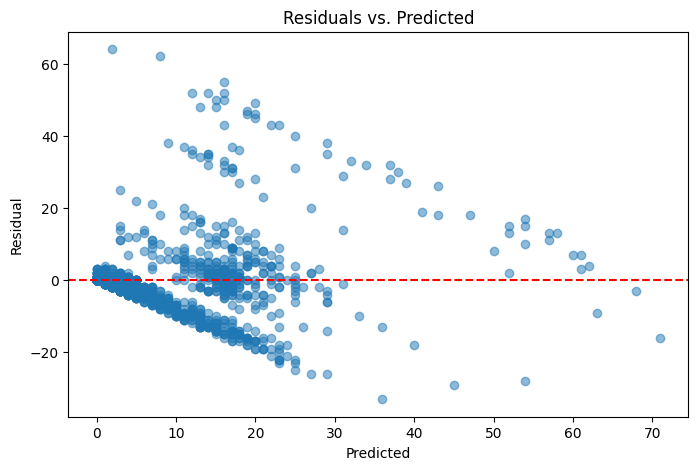

In [106]:
# Residual Analysis:
import matplotlib.pyplot as plt
import seaborn as sns

residuals = y_test - y_pred

plt.figure(figsize=(8, 5))
sns.histplot(residuals, kde=True)
plt.title("Residual Distribution")
plt.xlabel("Residual (Actual - Predicted)")
plt.show()

# Residuals vs predicted
plt.figure(figsize=(8, 5))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residuals vs. Predicted")
plt.xlabel("Predicted")
plt.ylabel("Residual")
plt.show()


In [107]:
#For Explainability
# Extracting SHAP Values
# SHAP explainer
explainer = shap.TreeExplainer(model)
shap_values = explainer(X)  # SHAP values for all rows

In [108]:
# Converting SHAP Values to DataFrame
shap_df = pd.DataFrame(shap_values.values, columns=X.columns) #columns=feature_cols
shap_df["model_output"] = shap_values.values.sum(axis=1) + shap_values.base_values #actual model output (the model’s prediction output for X)
shap_df["base_value"] = shap_values.base_values #the baseline prediction (base_value)
shap_df['region'] = df['region']
shap_df['country_code'] = df['country_code']
shap_df['Location'] = df['Location']
shap_df['year'] = df['year']
shap_df['month_number'] = df['month_number']
shap_df['Value'] = df['Value']

In [109]:
# Normalizing SHAP Scores (Climate Impact Weights)
# Computing absolute shap values per row
abs_shap = shap_df[feature_cols].abs()

# Normalizing by row total to get % contribution
norm_shap = abs_shap.div(abs_shap.sum(axis=1), axis=0)
norm_shap.columns = [col + '_weight' for col in norm_shap.columns]

# Combining with original data
impact_df = pd.concat([df[['region', 'country_code', 'Location', 'year', 'month_number', 'Value']], norm_shap], axis=1)

# Adding a “climate impact score” (magnitude of all SHAP)
impact_df['climate_score'] = shap_df[feature_cols].sum(axis=1)
impact_df['climate_score']  = np.round(np.clip(impact_df['climate_score'] , 0, None),0)

In [110]:
columns_to_keep = ['region', 'country_code', 'Location', 'year', 'month_number', 'Value', 'climate_score']
East_Africa = impact_df[columns_to_keep].copy()

# **Region Specific Model for North Africa**

##**Feature Selection**

In [111]:
df = final_df[final_df['region'] == 'North Africa'].copy().reset_index(drop=True)
exclude_cols = ['Value', 'year', 'month_number', 'Location', 'region', 'country_code']
numeric_cols = df.select_dtypes(include='number').columns
feature_cols = [col for col in numeric_cols if col not in exclude_cols]

# Feature Importance
df_model = df.copy()
X = df_model[feature_cols]
y = df_model['Value']
xgb_model = xgb.XGBRegressor(n_estimators=100, random_state=42)
xgb_model.fit(X, y)
importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance': xgb_model.feature_importances_
}).sort_values(by='importance', ascending=False)
top_features = importance_df.sort_values(by="importance", ascending=False)

In [112]:
# Computing correlation matrix
corr = df[feature_cols].corr().abs()

# Converting to distance matrix (1 - abs(correlation))
distance_matrix = 1 - corr

# Hierarchical clustering
linkage_matrix = linkage(squareform(distance_matrix), method='average')

# Assigning features to clusters
cluster_labels = fcluster(linkage_matrix, t=0.2, criterion='distance')
cluster_df = pd.DataFrame({'feature': corr.columns, 'cluster': cluster_labels})


# Merging cluster data with feature importance scores for final feature selection
features = pd.merge(cluster_df, top_features, on=['feature'], how='inner')

# Ranking within each cluster by descending importance
features['rank'] = features.groupby('cluster')['importance'] \
                           .rank(method='first', ascending=False)

features['selected'] = np.where(
    (features['rank'] == 1) & (features['importance'] > 0),
    'Select',
    ''
)

features = features.sort_values(by=["cluster", "importance"], ascending=[True, False]).reset_index(drop=True)
features['importance']= features['importance'].round(4)
features

,feature,cluster,importance,rank,selected
0,precip_range_lag3,1,0.0102,1.0,Select
1,max_precipitation_lag3,1,0.0008,2.0,
2,precip_range_roll3,2,0.0022,1.0,Select
3,max_precipitation_roll3,2,0.0012,2.0,
4,precip_range_roll6,3,0.3375,1.0,Select
5,max_precipitation_roll6,3,0.0151,2.0,
6,tmax_temperature_roll6,4,0.0517,1.0,Select
7,tmin_temperature_roll6,4,0.0290,2.0,
8,tmax_temperature_lag3,4,0.0289,3.0,
9,tmed_temperature_roll6,4,0.0189,4.0,


In [113]:
low_importance_collinear_features = features[features['selected'] != "Select"]['feature'].tolist()
# low_importance_collinear_features
df = df.drop(columns=low_importance_collinear_features)

In [114]:
# Features
exclude_cols = ['Value', 'year', 'month_number', 'Location', 'region', 'country_code']
numeric_cols = df.select_dtypes(include='number').columns
feature_cols = [col for col in numeric_cols if col not in exclude_cols]


# Group-based interpolation and fallback to global mean
df_imputed = df.copy()

# Applying backward fill to columns with little missing data
columns_to_bfill = df.columns[(df.isna().sum() >= 1) & (df.isna().sum() <= 49)]

df_imputed[columns_to_bfill] = (
    df.groupby('Location')[columns_to_bfill]
    .transform(lambda group: group.bfill())
)

# Interpolating missing values within each country
df_imputed[feature_cols] = (
    df.groupby('Location')[feature_cols]
    .transform(lambda group: group.fillna(group.mean()))
)

# Fallback: filling remaining NaNs with region-wise median
df_imputed[feature_cols] = (
    df_imputed
    .groupby('region')[feature_cols]
    .transform(lambda group: group.fillna(group.median()))
)

# Final fallback: fill any still-missing values with global column median
df_imputed[feature_cols] = df_imputed[feature_cols].fillna(df_imputed[feature_cols].median())

In [115]:
# VIF
X = df_imputed[feature_cols]
constant_filter = VarianceThreshold(threshold=0.0)
X = X.loc[:, constant_filter.fit(X).get_support()]
X = add_constant(X)
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                   for i in range(X.shape[1])]
vif_data = vif_data[vif_data["feature"] != "const"]

# Merging both
features = pd.merge(vif_data, features[['feature', 'importance']], on=['feature'], how='left')
features = features.sort_values(by='importance', ascending=False)
features.reset_index(drop=True)

,feature,VIF,importance
0,precip_range_roll6,6.876274,0.3375
1,temp_range_roll6,10.767627,0.0645
2,tmax_temperature_roll6,16.459809,0.0517
3,month_sin,6.940025,0.0401
4,max_aod_lag1,2.816999,0.0384
5,max_aod,1.216810,0.0367
6,med_precipitation_roll6,3.687005,0.0334
7,temp_range_lag1,5.666101,0.0206
8,max_aod_lag3,2.811400,0.0194
9,max_aod_roll3,6.859092,0.0150


In [116]:
high_VIF_features = features[features['VIF'] > 7]['feature'].tolist()
# high_VIF_features
df = df.drop(columns=high_VIF_features)

## **Selected Features**

In [117]:
# Features
exclude_cols = ['Value', 'year', 'month_number', 'Location', 'region', 'country_code']
numeric_cols = df.select_dtypes(include='number').columns
feature_cols = [col for col in numeric_cols if col not in exclude_cols]

# Feature Importance
df_model = df.copy()
X = df_model[feature_cols]
y = df_model['Value']
xgb_model = xgb.XGBRegressor(n_estimators=100, random_state=42)
xgb_model.fit(X, y)
importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance': xgb_model.feature_importances_
}).sort_values(by='importance', ascending=False)
top_features = importance_df.sort_values(by="importance", ascending=False)


# VIF
X = df_imputed[feature_cols]
constant_filter = VarianceThreshold(threshold=0.0)
X = X.loc[:, constant_filter.fit(X).get_support()]
X = add_constant(X)
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                   for i in range(X.shape[1])]
vif_data = vif_data[vif_data["feature"] != "const"]

# Merging both
features = pd.merge(top_features, vif_data, on=['feature'], how='inner')
features = features.sort_values(by='importance', ascending=False).reset_index(drop=True)
features


,feature,importance,VIF
0,precip_range_roll6,0.402943,3.420131
1,max_aod,0.070696,1.194258
2,temp_range_lag1,0.062771,1.983423
3,max_aod_roll3,0.062663,6.569421
4,med_precipitation_roll6,0.057875,1.483092
5,month_sin,0.057655,1.483150
6,max_aod_lag3,0.057418,2.768410
7,max_aod_lag1,0.051685,2.792012
8,max_precipitation,0.043049,2.066503
9,med_precipitation_lag1,0.025485,3.653042


##**Modeling**

In [118]:
# XGBoost Model

X = df[feature_cols]
y = df['Value']  # mortality

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Training XGBoost

# Initial model
# model = xgb.XGBRegressor(
#     n_estimators=100,
#     learning_rate=0.1,
#     max_depth=4,
#     random_state=42
# )
# model.fit(X_train, y_train)

# Optimized model
model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=1000, # More trees to allow learning more complex patterns
    early_stopping_rounds=50, # adding stop if no improvement in 50 rounds to prevent long training & avoid overfitting
    eval_metric='rmse',
    learning_rate=0.05, #Lower learning rate for better generalization
    max_depth=6, #Deeper trees to model interactions better
    subsample=0.8, #Introducing row sampling for regularization to reduce overfitting
    colsample_bytree=0.8, # including feature sampling per tree to improve generalization
    random_state=42
)


# Fitting with eval set
model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    verbose=False
)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [119]:
# Access best iteration and score
print(f"Best iteration: {model.best_iteration}")
print(f"Best score on validation set: {model.best_score}")

# Make predictions using the best model
predictions = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f"RMSE on validation set using best model: {rmse}")

Best iteration: 447
Best score on validation set: 1.9394463443001617
RMSE on validation set using best model: 1.9394463637926584


In [120]:
# Regression Metrics

y_pred = model.predict(X_test)
y_pred = np.round(np.clip(y_pred, 0, None),0)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R²: {r2:.3f}")
print(f"MAPE: {mape:.2f}")

RMSE: 1.93
MAE: 1.05
R²: 0.778


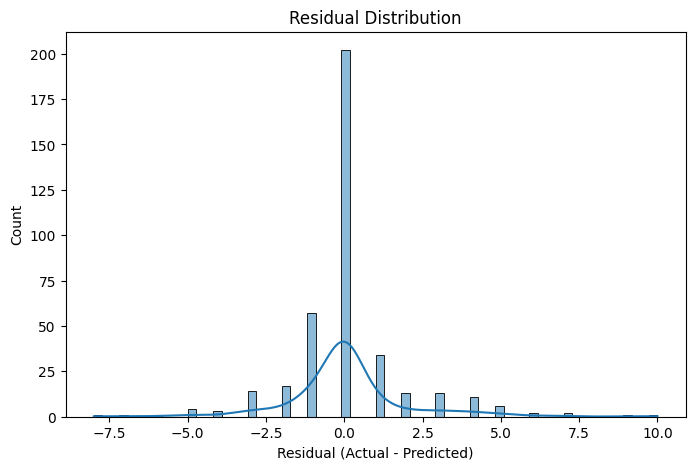

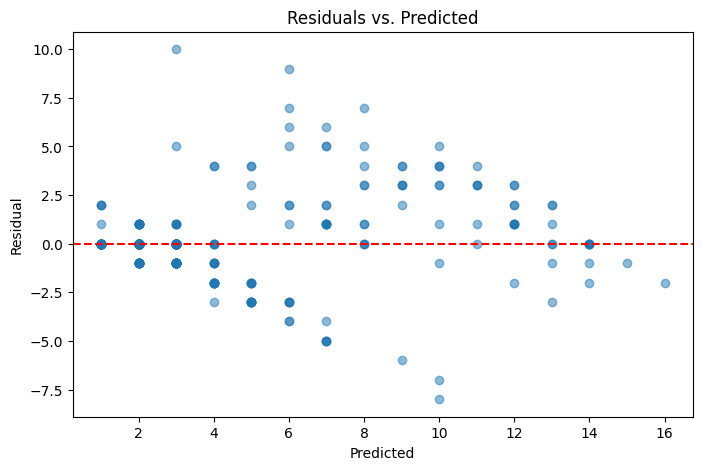

In [121]:
# Residual Analysis:
import matplotlib.pyplot as plt
import seaborn as sns

residuals = y_test - y_pred

plt.figure(figsize=(8, 5))
sns.histplot(residuals, kde=True)
plt.title("Residual Distribution")
plt.xlabel("Residual (Actual - Predicted)")
plt.show()

# Residuals vs predicted
plt.figure(figsize=(8, 5))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residuals vs. Predicted")
plt.xlabel("Predicted")
plt.ylabel("Residual")
plt.show()


In [122]:
#For Explainability
# Extracting SHAP Values
# SHAP explainer
explainer = shap.TreeExplainer(model)
shap_values = explainer(X)  # SHAP values for all rows

In [123]:
# Converting SHAP Values to DataFrame
shap_df = pd.DataFrame(shap_values.values, columns=X.columns) #columns=feature_cols
shap_df["model_output"] = shap_values.values.sum(axis=1) + shap_values.base_values #actual model output (the model’s prediction output for X)
shap_df["base_value"] = shap_values.base_values #the baseline prediction (base_value)
shap_df['region'] = df['region']
shap_df['country_code'] = df['country_code']
shap_df['Location'] = df['Location']
shap_df['year'] = df['year']
shap_df['month_number'] = df['month_number']
shap_df['Value'] = df['Value']

In [124]:
# Normalizing SHAP Scores (Climate Impact Weights)
# Computing absolute shap values per row
abs_shap = shap_df[feature_cols].abs()

# Normalizing by row total to get % contribution
norm_shap = abs_shap.div(abs_shap.sum(axis=1), axis=0)
norm_shap.columns = [col + '_weight' for col in norm_shap.columns]

# Combining with original data
impact_df = pd.concat([df[['region', 'country_code', 'Location', 'year', 'month_number', 'Value']], norm_shap], axis=1)

# Adding a “climate impact score” (magnitude of all SHAP)
impact_df['climate_score'] = shap_df[feature_cols].sum(axis=1)
impact_df['climate_score']  = np.round(np.clip(impact_df['climate_score'] , 0, None),0)

In [125]:
columns_to_keep = ['region', 'country_code', 'Location', 'year', 'month_number', 'Value', 'climate_score']
North_Africa = impact_df[columns_to_keep].copy()

# **Region Specific Model for Southern Africa**

##**Feature Selection**

In [126]:
df = final_df[final_df['region'] == 'Southern Africa'].copy().reset_index(drop=True)
exclude_cols = ['Value', 'year', 'month_number', 'Location', 'region', 'country_code']
numeric_cols = df.select_dtypes(include='number').columns
feature_cols = [col for col in numeric_cols if col not in exclude_cols]

# Feature Importance
df_model = df.copy()
X = df_model[feature_cols]
y = df_model['Value']
xgb_model = xgb.XGBRegressor(n_estimators=100, random_state=42)
xgb_model.fit(X, y)
importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance': xgb_model.feature_importances_
}).sort_values(by='importance', ascending=False)
top_features = importance_df.sort_values(by="importance", ascending=False)

In [127]:
# Computing correlation matrix
corr = df[feature_cols].corr().abs()

# Converting to distance matrix (1 - abs(correlation))
distance_matrix = 1 - corr

# Hierarchical clustering
linkage_matrix = linkage(squareform(distance_matrix), method='average')

# Assigning features to clusters
cluster_labels = fcluster(linkage_matrix, t=0.2, criterion='distance')
cluster_df = pd.DataFrame({'feature': corr.columns, 'cluster': cluster_labels})


# Merging cluster data with feature importance scores for final feature selection
features = pd.merge(cluster_df, top_features, on=['feature'], how='inner')

# Ranking within each cluster by descending importance
features['rank'] = features.groupby('cluster')['importance'] \
                           .rank(method='first', ascending=False)

features['selected'] = np.where(
    (features['rank'] == 1) & (features['importance'] > 0),
    'Select',
    ''
)

features = features.sort_values(by=["cluster", "importance"], ascending=[True, False]).reset_index(drop=True)
features['importance']= features['importance'].round(4)
features

,feature,cluster,importance,rank,selected
0,tmax_temperature_roll6,1,0.0084,1.0,Select
1,tmax_temperature_lag3,1,0.0017,2.0,
2,tmin_temperature_roll6,2,0.1252,1.0,Select
3,tmin_temperature_lag3,2,0.0194,2.0,
4,tmed_temperature_roll6,2,0.0158,3.0,
5,tmed_temperature_lag3,2,0.0122,4.0,
6,tmax_temperature_roll3,3,0.0130,1.0,Select
7,tmax_temperature_lag1,3,0.0036,2.0,
8,tmax_temperature,3,0.0013,3.0,
9,tmin_temperature,4,0.0167,1.0,Select


In [128]:
low_importance_collinear_features = features[features['selected'] != "Select"]['feature'].tolist()
# low_importance_collinear_features
df = df.drop(columns=low_importance_collinear_features)

In [129]:
# Features
exclude_cols = ['Value', 'year', 'month_number', 'Location', 'region', 'country_code']
numeric_cols = df.select_dtypes(include='number').columns
feature_cols = [col for col in numeric_cols if col not in exclude_cols]


# Group-based interpolation and fallback to global mean
df_imputed = df.copy()

# Applying backward fill to columns with little missing data
columns_to_bfill = df.columns[(df.isna().sum() >= 1) & (df.isna().sum() <= 49)]

df_imputed[columns_to_bfill] = (
    df.groupby('Location')[columns_to_bfill]
    .transform(lambda group: group.bfill())
)

# Interpolating missing values within each country
df_imputed[feature_cols] = (
    df.groupby('Location')[feature_cols]
    .transform(lambda group: group.fillna(group.mean()))
)

# Fallback: filling remaining NaNs with region-wise median
df_imputed[feature_cols] = (
    df_imputed
    .groupby('region')[feature_cols]
    .transform(lambda group: group.fillna(group.median()))
)

# Final fallback: fill any still-missing values with global column median
df_imputed[feature_cols] = df_imputed[feature_cols].fillna(df_imputed[feature_cols].median())

In [130]:
# VIF
X = df_imputed[feature_cols]
constant_filter = VarianceThreshold(threshold=0.0)
X = X.loc[:, constant_filter.fit(X).get_support()]
X = add_constant(X)
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                   for i in range(X.shape[1])]
vif_data = vif_data[vif_data["feature"] != "const"]

# Merging both
features = pd.merge(vif_data, features[['feature', 'importance']], on=['feature'], how='left')
features = features.sort_values(by='importance', ascending=False)
features.reset_index(drop=True)

/usr/local/lib/python3.11/dist-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


,feature,VIF,importance
0,max_aod_roll6,5.246309,0.1888
1,temp_range_roll6,inf,0.1540
2,precip_range,2.934754,0.1269
3,tmin_temperature_roll6,inf,0.1252
4,min_precipitation_roll6,inf,0.0329
5,tmin_temperature_roll3,42.908131,0.0293
6,month_sin,8.015147,0.0240
7,precip_range_roll6,inf,0.0238
8,tmin_temperature,9.249909,0.0167
9,aridity_index_roll3,16.888493,0.0161


In [131]:
high_VIF_features = features[features['VIF'] > 7]['feature'].tolist()
# high_VIF_features
df = df.drop(columns=high_VIF_features)

## **Selected Features**

In [132]:
# Features
exclude_cols = ['Value', 'year', 'month_number', 'Location', 'region', 'country_code']
numeric_cols = df.select_dtypes(include='number').columns
feature_cols = [col for col in numeric_cols if col not in exclude_cols]

# Feature Importance
df_model = df.copy()
X = df_model[feature_cols]
y = df_model['Value']
xgb_model = xgb.XGBRegressor(n_estimators=100, random_state=42)
xgb_model.fit(X, y)
importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance': xgb_model.feature_importances_
}).sort_values(by='importance', ascending=False)
top_features = importance_df.sort_values(by="importance", ascending=False)


# VIF
X = df_imputed[feature_cols]
constant_filter = VarianceThreshold(threshold=0.0)
X = X.loc[:, constant_filter.fit(X).get_support()]
X = add_constant(X)
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                   for i in range(X.shape[1])]
vif_data = vif_data[vif_data["feature"] != "const"]

# Merging both
features = pd.merge(top_features, vif_data, on=['feature'], how='inner')
features = features.sort_values(by='importance', ascending=False).reset_index(drop=True)
features


,feature,importance,VIF
0,max_aod_roll6,0.522888,4.443036
1,min_precipitation,0.095762,2.087917
2,med_precipitation_lag3,0.076631,1.311307
3,precip_range,0.064151,2.212246
4,precip_range_lag1,0.054086,2.707271
5,max_aod_lag3,0.054078,2.368699
6,max_aod,0.044927,1.647828
7,med_precipitation_lag1,0.044207,2.437224
8,max_aod_lag1,0.043269,2.249648


##**Modeling**

In [133]:
# XGBoost Model

X = df[feature_cols]
y = df['Value']  # mortality

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Training XGBoost

# Initial model
# model = xgb.XGBRegressor(
#     n_estimators=100,
#     learning_rate=0.1,
#     max_depth=4,
#     random_state=42
# )
# model.fit(X_train, y_train)

# Optimized model
model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=1000, # More trees to allow learning more complex patterns
    early_stopping_rounds=50, # adding stop if no improvement in 50 rounds to prevent long training & avoid overfitting
    eval_metric='rmse',
    learning_rate=0.05, #Lower learning rate for better generalization
    max_depth=6, #Deeper trees to model interactions better
    subsample=0.8, #Introducing row sampling for regularization to reduce overfitting
    colsample_bytree=0.8, # including feature sampling per tree to improve generalization
    random_state=42
)


# Fitting with eval set
model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    verbose=False
)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [134]:
# Access best iteration and score
print(f"Best iteration: {model.best_iteration}")
print(f"Best score on validation set: {model.best_score}")

# Make predictions using the best model
predictions = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f"RMSE on validation set using best model: {rmse}")

Best iteration: 208
Best score on validation set: 0.38482059151573617
RMSE on validation set using best model: 0.38482059531458285


In [135]:
# Regression Metrics

y_pred = model.predict(X_test)
y_pred = np.round(np.clip(y_pred, 0, None),0)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R²: {r2:.3f}")
print(f"MAPE: {mape:.2f}")

RMSE: 0.40
MAE: 0.15
R²: 0.780


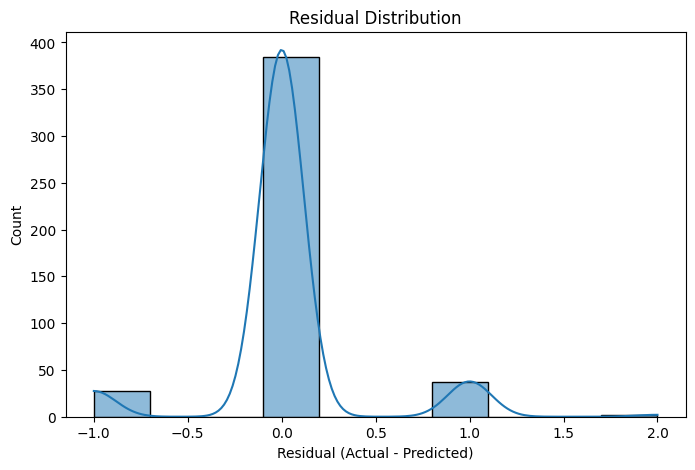

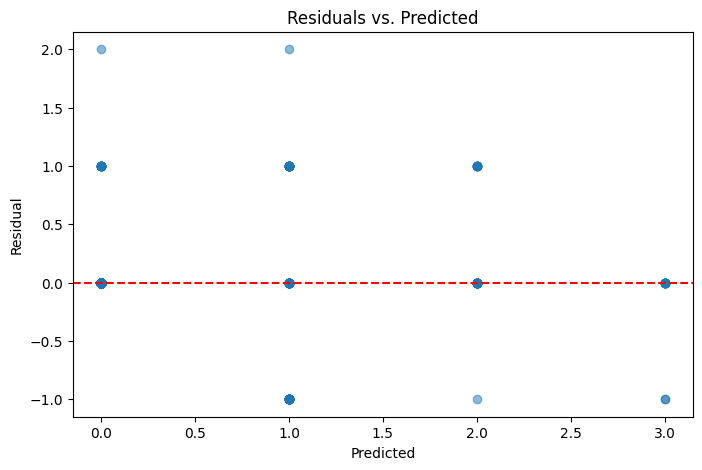

In [136]:
# Residual Analysis:
import matplotlib.pyplot as plt
import seaborn as sns

residuals = y_test - y_pred

plt.figure(figsize=(8, 5))
sns.histplot(residuals, kde=True)
plt.title("Residual Distribution")
plt.xlabel("Residual (Actual - Predicted)")
plt.show()

# Residuals vs predicted
plt.figure(figsize=(8, 5))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residuals vs. Predicted")
plt.xlabel("Predicted")
plt.ylabel("Residual")
plt.show()


In [137]:
#For Explainability
# Extracting SHAP Values
# SHAP explainer
explainer = shap.TreeExplainer(model)
shap_values = explainer(X)  # SHAP values for all rows

In [138]:
# Converting SHAP Values to DataFrame
shap_df = pd.DataFrame(shap_values.values, columns=X.columns) #columns=feature_cols
shap_df["model_output"] = shap_values.values.sum(axis=1) + shap_values.base_values #actual model output (the model’s prediction output for X)
shap_df["base_value"] = shap_values.base_values #the baseline prediction (base_value)
shap_df['region'] = df['region']
shap_df['country_code'] = df['country_code']
shap_df['Location'] = df['Location']
shap_df['year'] = df['year']
shap_df['month_number'] = df['month_number']
shap_df['Value'] = df['Value']

In [139]:
# Normalizing SHAP Scores (Climate Impact Weights)
# Computing absolute shap values per row
abs_shap = shap_df[feature_cols].abs()

# Normalizing by row total to get % contribution
norm_shap = abs_shap.div(abs_shap.sum(axis=1), axis=0)
norm_shap.columns = [col + '_weight' for col in norm_shap.columns]

# Combining with original data
impact_df = pd.concat([df[['region', 'country_code', 'Location', 'year', 'month_number', 'Value']], norm_shap], axis=1)

# Adding a “climate impact score” (magnitude of all SHAP)
impact_df['climate_score'] = shap_df[feature_cols].sum(axis=1)
impact_df['climate_score']  = np.round(np.clip(impact_df['climate_score'] , 0, None),0)

In [140]:
columns_to_keep = ['region', 'country_code', 'Location', 'year', 'month_number', 'Value', 'climate_score']
Southern_Africa = impact_df[columns_to_keep].copy()

# **Region Specific Model for West Africa**

##**Feature Selection**

In [141]:
df = final_df[final_df['region'] == 'West Africa'].copy().reset_index(drop=True)
exclude_cols = ['Value', 'year', 'month_number', 'Location', 'region', 'country_code']
numeric_cols = df.select_dtypes(include='number').columns
feature_cols = [col for col in numeric_cols if col not in exclude_cols]

# Feature Importance
df_model = df.copy()
X = df_model[feature_cols]
y = df_model['Value']
xgb_model = xgb.XGBRegressor(n_estimators=100, random_state=42)
xgb_model.fit(X, y)
importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance': xgb_model.feature_importances_
}).sort_values(by='importance', ascending=False)
top_features = importance_df.sort_values(by="importance", ascending=False)

In [142]:
# Computing correlation matrix
corr = df[feature_cols].corr().abs()

# Converting to distance matrix (1 - abs(correlation))
distance_matrix = 1 - corr

# Hierarchical clustering
linkage_matrix = linkage(squareform(distance_matrix), method='average')

# Assigning features to clusters
cluster_labels = fcluster(linkage_matrix, t=0.2, criterion='distance')
cluster_df = pd.DataFrame({'feature': corr.columns, 'cluster': cluster_labels})


# Merging cluster data with feature importance scores for final feature selection
features = pd.merge(cluster_df, top_features, on=['feature'], how='inner')

# Ranking within each cluster by descending importance
features['rank'] = features.groupby('cluster')['importance'] \
                           .rank(method='first', ascending=False)

features['selected'] = np.where(
    (features['rank'] == 1) & (features['importance'] > 0),
    'Select',
    ''
)

features = features.sort_values(by=["cluster", "importance"], ascending=[True, False]).reset_index(drop=True)
features['importance']= features['importance'].round(4)
features

,feature,cluster,importance,rank,selected
0,max_aod_roll6,1,0.2153,1.0,Select
1,max_aod_roll3,1,0.0062,2.0,
2,max_aod_lag3,2,0.0080,1.0,Select
3,max_aod_lag1,3,0.0009,1.0,Select
4,max_aod,4,0.0008,1.0,Select
5,tmin_temperature_lag1,5,0.0082,1.0,Select
6,tmin_temperature_roll3,5,0.0029,2.0,
7,tmin_temperature,6,0.0021,1.0,Select
8,tmin_temperature_roll6,7,0.0400,1.0,Select
9,tmin_temperature_lag3,7,0.0049,2.0,


In [143]:
low_importance_collinear_features = features[features['selected'] != "Select"]['feature'].tolist()
# low_importance_collinear_features
df = df.drop(columns=low_importance_collinear_features)

In [144]:
# Features
exclude_cols = ['Value', 'year', 'month_number', 'Location', 'region', 'country_code']
numeric_cols = df.select_dtypes(include='number').columns
feature_cols = [col for col in numeric_cols if col not in exclude_cols]


# Group-based interpolation and fallback to global mean
df_imputed = df.copy()

# Applying backward fill to columns with little missing data
columns_to_bfill = df.columns[(df.isna().sum() >= 1) & (df.isna().sum() <= 49)]

df_imputed[columns_to_bfill] = (
    df.groupby('Location')[columns_to_bfill]
    .transform(lambda group: group.bfill())
)

# Interpolating missing values within each country
df_imputed[feature_cols] = (
    df.groupby('Location')[feature_cols]
    .transform(lambda group: group.fillna(group.mean()))
)

# Fallback: filling remaining NaNs with region-wise median
df_imputed[feature_cols] = (
    df_imputed
    .groupby('region')[feature_cols]
    .transform(lambda group: group.fillna(group.median()))
)

# Final fallback: fill any still-missing values with global column median
df_imputed[feature_cols] = df_imputed[feature_cols].fillna(df_imputed[feature_cols].median())

In [145]:
# VIF
X = df_imputed[feature_cols]
constant_filter = VarianceThreshold(threshold=0.0)
X = X.loc[:, constant_filter.fit(X).get_support()]
X = add_constant(X)
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                   for i in range(X.shape[1])]
vif_data = vif_data[vif_data["feature"] != "const"]

# Merging both
features = pd.merge(vif_data, features[['feature', 'importance']], on=['feature'], how='left')
features = features.sort_values(by='importance', ascending=False)
features.reset_index(drop=True)

,feature,VIF,importance
0,max_aod_roll6,2.878735,0.2153
1,min_precipitation_roll6,5.220458,0.1948
2,precip_range_roll6,6.864665,0.1848
3,temp_range_roll3,23.523286,0.0645
4,tmin_temperature_roll6,15.412403,0.0400
5,max_precipitation_roll3,23.326436,0.0223
6,precip_range,2.631989,0.0162
7,tmed_temperature_roll6,10.228242,0.0135
8,month_sin,3.733070,0.0104
9,month_cos,3.771745,0.0101


In [146]:
high_VIF_features = features[features['VIF'] > 7]['feature'].tolist()
# high_VIF_features
df = df.drop(columns=high_VIF_features)

## **Selected Features**

In [147]:
# Features
exclude_cols = ['Value', 'year', 'month_number', 'Location', 'region', 'country_code']
numeric_cols = df.select_dtypes(include='number').columns
feature_cols = [col for col in numeric_cols if col not in exclude_cols]

# Feature Importance
df_model = df.copy()
X = df_model[feature_cols]
y = df_model['Value']
xgb_model = xgb.XGBRegressor(n_estimators=100, random_state=42)
xgb_model.fit(X, y)
importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance': xgb_model.feature_importances_
}).sort_values(by='importance', ascending=False)
top_features = importance_df.sort_values(by="importance", ascending=False)


# VIF
X = df_imputed[feature_cols]
constant_filter = VarianceThreshold(threshold=0.0)
X = X.loc[:, constant_filter.fit(X).get_support()]
X = add_constant(X)
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                   for i in range(X.shape[1])]
vif_data = vif_data[vif_data["feature"] != "const"]

# Merging both
features = pd.merge(top_features, vif_data, on=['feature'], how='inner')
features = features.sort_values(by='importance', ascending=False).reset_index(drop=True)
features


,feature,importance,VIF
0,max_aod_roll6,0.332737,2.782891
1,precip_range_roll6,0.253623,2.380987
2,min_precipitation_roll6,0.189259,2.296235
3,month_sin,0.048110,1.468109
4,max_aod_lag3,0.036576,1.837770
5,precip_range,0.033665,2.409064
6,max_aod,0.028627,1.321718
7,min_precipitation,0.021039,2.207932
8,tmin_temperature,0.019135,1.497887
9,tmax_temperature,0.019038,2.312427


##**Modeling**

In [148]:
# XGBoost Model

X = df[feature_cols]
y = df['Value']  # mortality

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Training XGBoost

# Initial model
# model = xgb.XGBRegressor(
#     n_estimators=100,
#     learning_rate=0.1,
#     max_depth=4,
#     random_state=42
# )
# model.fit(X_train, y_train)

# Optimized model
model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=1000, # More trees to allow learning more complex patterns
    early_stopping_rounds=50, # adding stop if no improvement in 50 rounds to prevent long training & avoid overfitting
    eval_metric='rmse',
    learning_rate=0.05, #Lower learning rate for better generalization
    max_depth=6, #Deeper trees to model interactions better
    subsample=0.8, #Introducing row sampling for regularization to reduce overfitting
    colsample_bytree=0.8, # including feature sampling per tree to improve generalization
    random_state=42
)


# Fitting with eval set
model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    verbose=False
)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [149]:
# Access best iteration and score
print(f"Best iteration: {model.best_iteration}")
print(f"Best score on validation set: {model.best_score}")

# Make predictions using the best model
predictions = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f"RMSE on validation set using best model: {rmse}")

Best iteration: 999
Best score on validation set: 52.64730117936251
RMSE on validation set using best model: 52.64730079738182


In [150]:
# Regression Metrics

y_pred = model.predict(X_test)
y_pred = np.round(np.clip(y_pred, 0, None),0)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R²: {r2:.3f}")
print(f"MAPE: {mape:.2f}")

RMSE: 52.59
MAE: 28.98
R²: 0.932


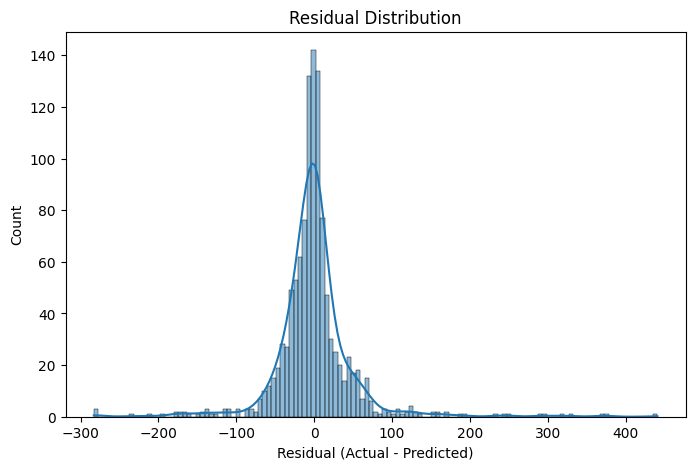

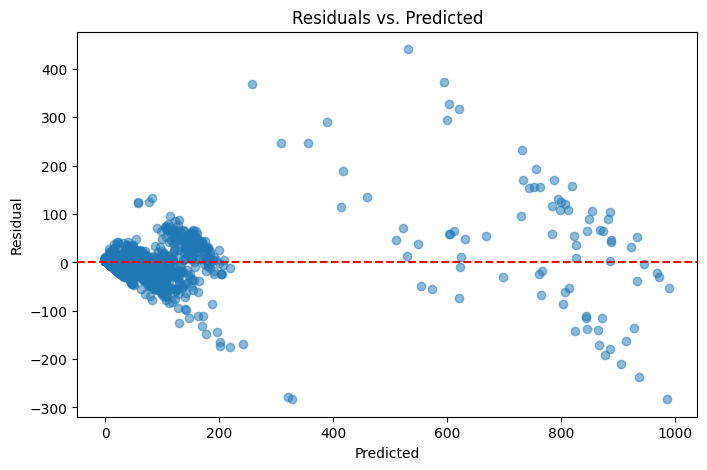

In [151]:
# Residual Analysis:
import matplotlib.pyplot as plt
import seaborn as sns

residuals = y_test - y_pred

plt.figure(figsize=(8, 5))
sns.histplot(residuals, kde=True)
plt.title("Residual Distribution")
plt.xlabel("Residual (Actual - Predicted)")
plt.show()

# Residuals vs predicted
plt.figure(figsize=(8, 5))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residuals vs. Predicted")
plt.xlabel("Predicted")
plt.ylabel("Residual")
plt.show()


In [152]:
#For Explainability
# Extracting SHAP Values
# SHAP explainer
explainer = shap.TreeExplainer(model)
shap_values = explainer(X)  # SHAP values for all rows

In [153]:
# Converting SHAP Values to DataFrame
shap_df = pd.DataFrame(shap_values.values, columns=X.columns) #columns=feature_cols
shap_df["model_output"] = shap_values.values.sum(axis=1) + shap_values.base_values #actual model output (the model’s prediction output for X)
shap_df["base_value"] = shap_values.base_values #the baseline prediction (base_value)
shap_df['region'] = df['region']
shap_df['country_code'] = df['country_code']
shap_df['Location'] = df['Location']
shap_df['year'] = df['year']
shap_df['month_number'] = df['month_number']
shap_df['Value'] = df['Value']

In [154]:
# Normalizing SHAP Scores (Climate Impact Weights)
# Computing absolute shap values per row
abs_shap = shap_df[feature_cols].abs()

# Normalizing by row total to get % contribution
norm_shap = abs_shap.div(abs_shap.sum(axis=1), axis=0)
norm_shap.columns = [col + '_weight' for col in norm_shap.columns]

# Combining with original data
impact_df = pd.concat([df[['region', 'country_code', 'Location', 'year', 'month_number', 'Value']], norm_shap], axis=1)

# Adding a “climate impact score” (magnitude of all SHAP)
impact_df['climate_score'] = shap_df[feature_cols].sum(axis=1)
impact_df['climate_score']  = np.round(np.clip(impact_df['climate_score'] , 0, None),0)

In [155]:
columns_to_keep = ['region', 'country_code', 'Location', 'year', 'month_number', 'Value', 'climate_score']
West_Africa = impact_df[columns_to_keep].copy()

#**SHAP**

In [ ]:
np.allclose(shap_values.values.sum(axis=1) + explainer.expected_value, model.predict(X))

False

In [ ]:
shap_pred = shap_values.values.sum(axis=1) + explainer.expected_value
model_pred = model.predict(X)

assert np.allclose(shap_pred, model_pred)

AssertionError: 

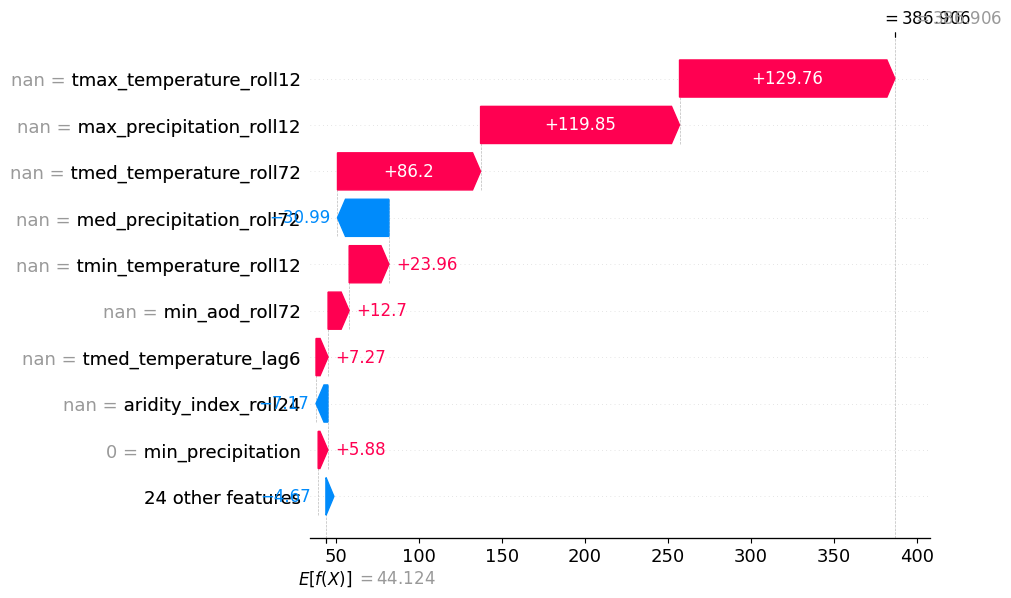

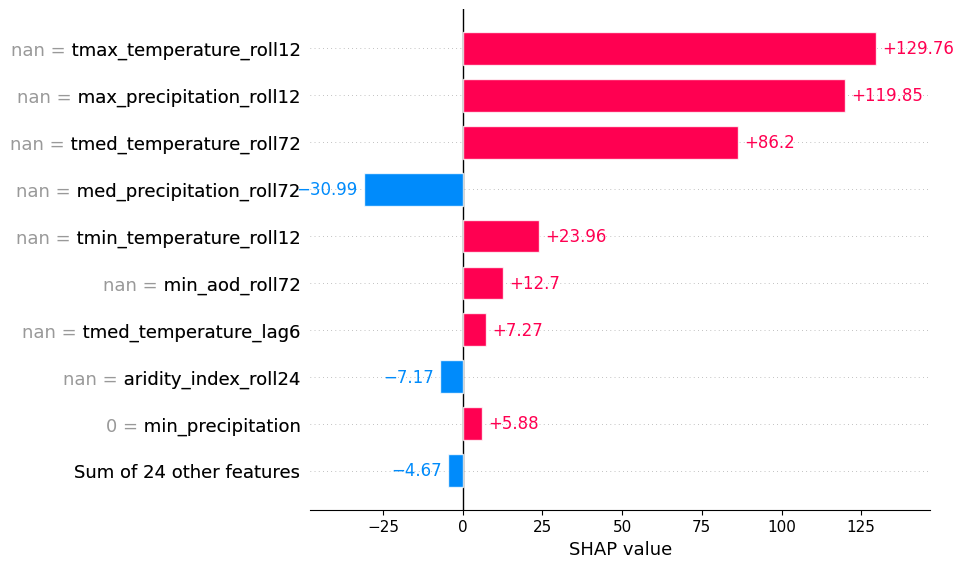

In [ ]:
#  Validation for one row
shap.plots.waterfall(shap_values[0])  # for first row
shap.plots.bar(shap_values[0])        # feature importance for one prediction

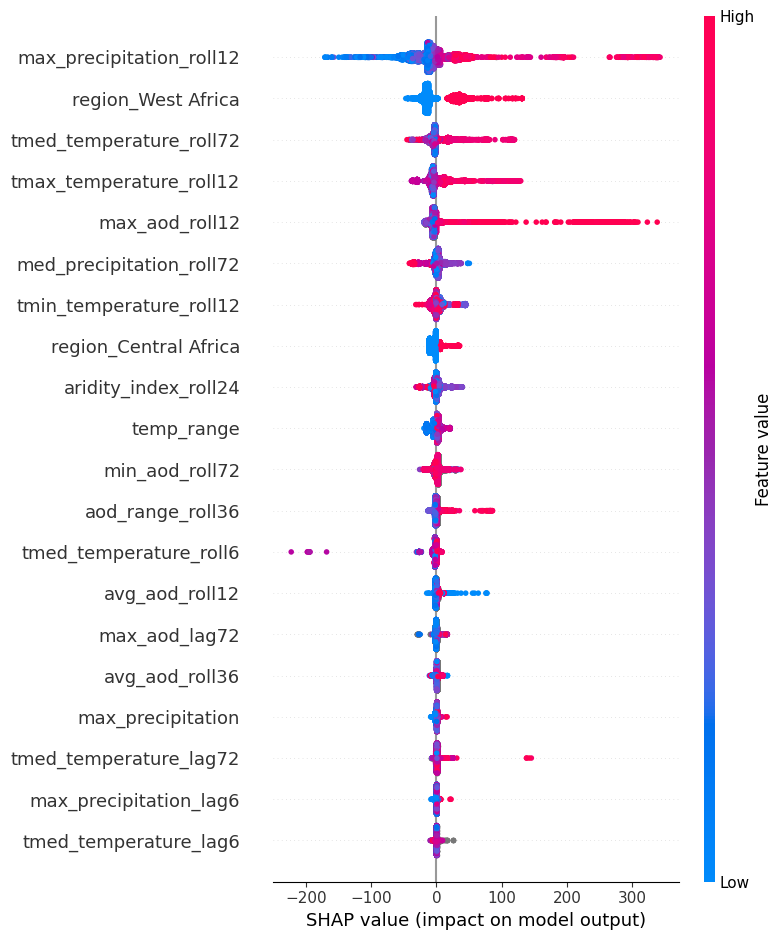

In [ ]:
# SHAP Beeswarm Plot (global impact)
shap.summary_plot(shap_values, X, feature_names=feature_cols)


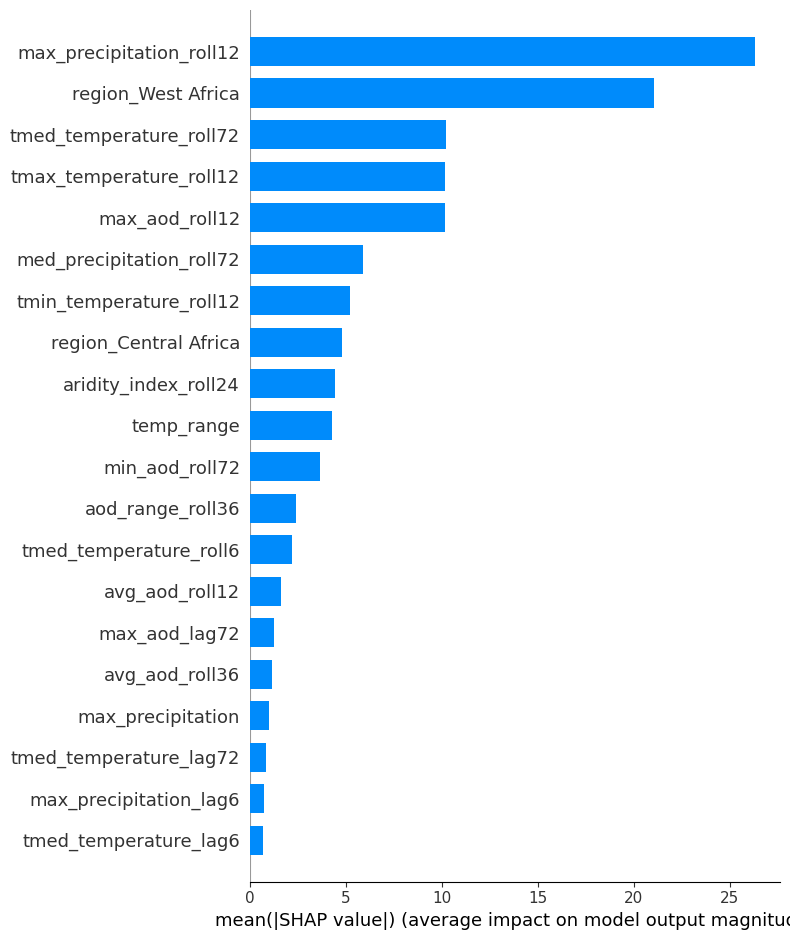

In [ ]:
# SHAP Summary (bar)
shap.summary_plot(shap_values.values, X, feature_names=feature_cols, plot_type='bar')

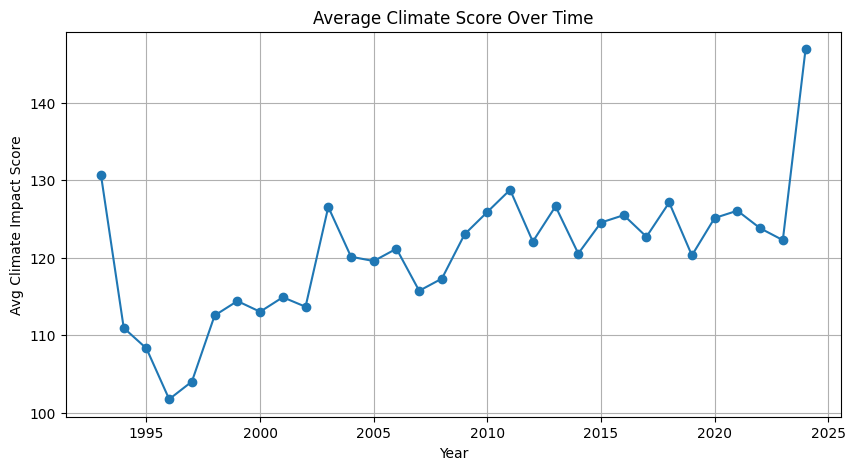

In [ ]:
# Climate Score Over Time / Countries
# Trend over years (global avg)
trend = impact_df.groupby('year')['climate_score'].mean()

plt.figure(figsize=(10, 5))
trend.plot(marker='o')
plt.title("Average Climate Score Over Time")
plt.ylabel("Avg Climate Impact Score")
plt.xlabel("Year")
plt.grid(True)
plt.show()


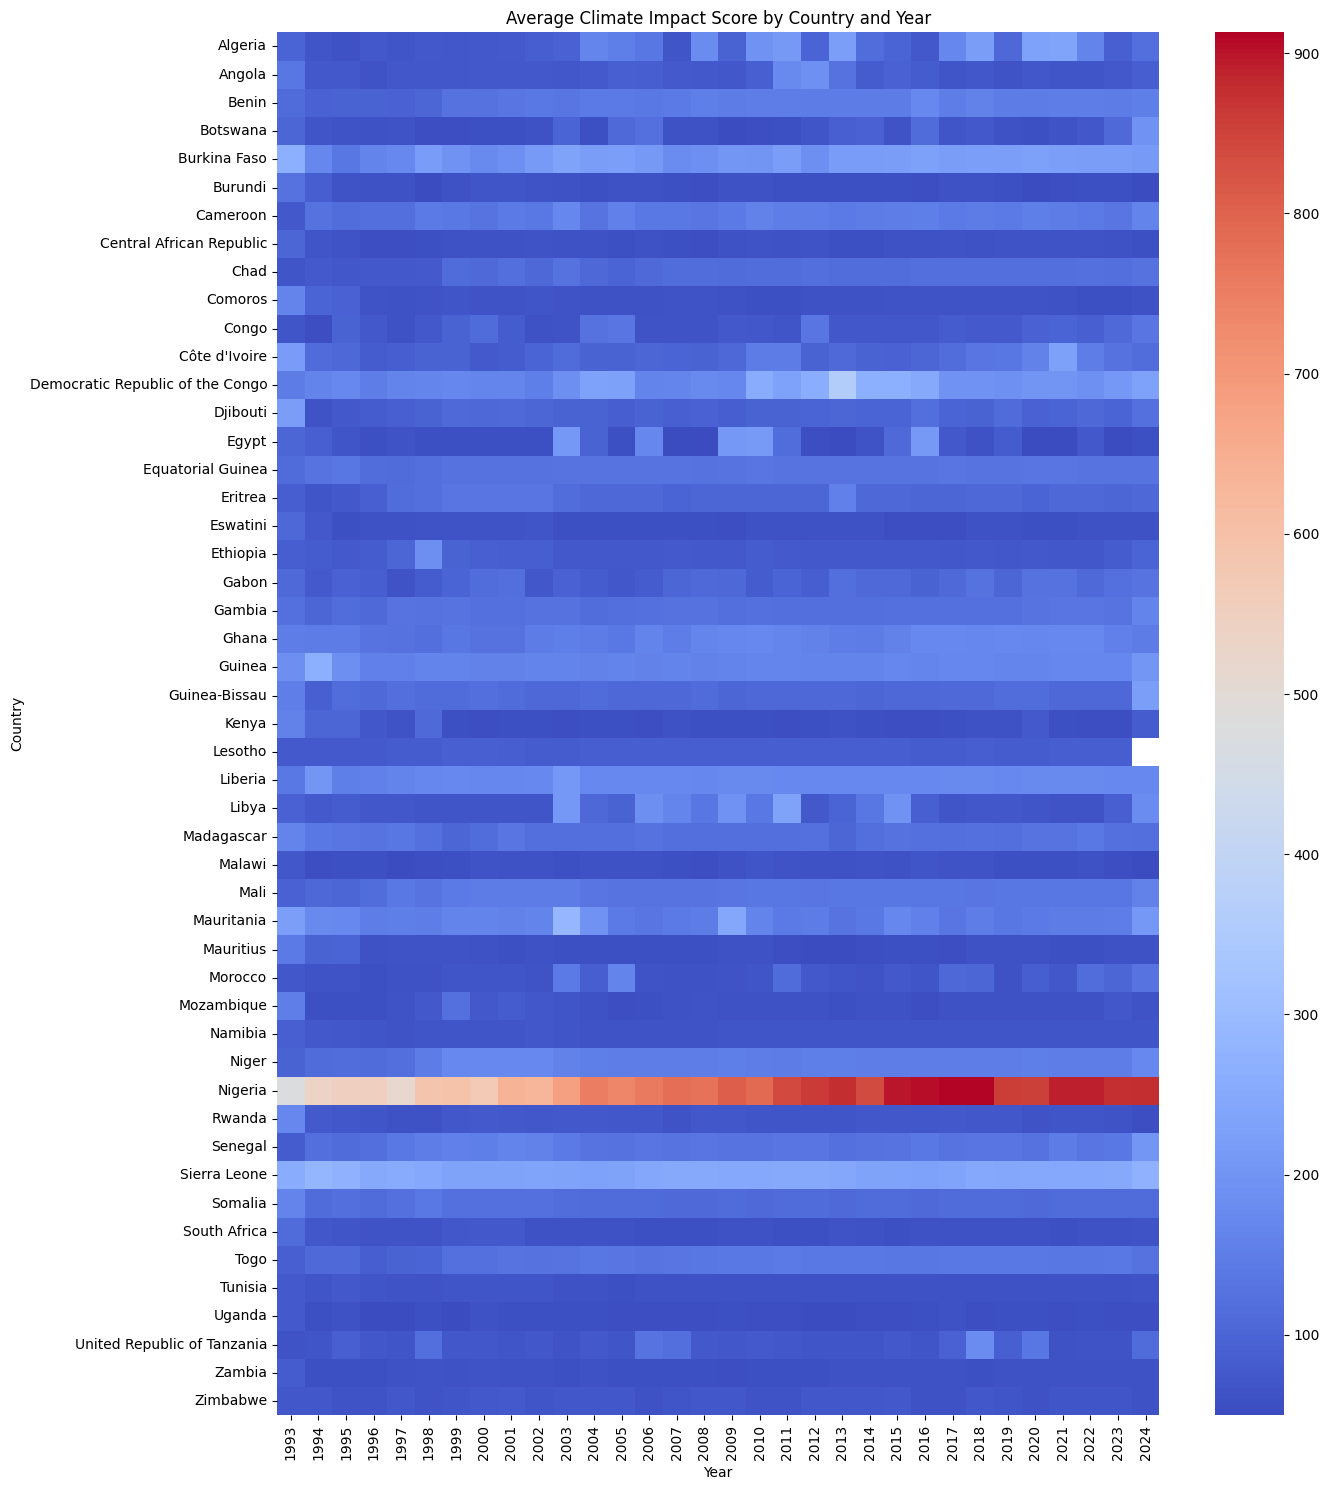

In [ ]:
# Climate Score Over Time / Countries
# Heatmap by country-year

avg_scores = impact_df.groupby(['Location', 'year'], as_index=False)['climate_score'].mean()
pivot = avg_scores.pivot(index='Location', columns='year', values='climate_score')

plt.figure(figsize=(14, 15))
sns.heatmap(pivot, cmap='coolwarm', annot=False)
plt.title("Average Climate Impact Score by Country and Year")
plt.xlabel("Year")
plt.ylabel("Country")
plt.tight_layout()
plt.show()

#**Visualization**

In [156]:
df_combined = pd.concat([Central_Africa, East_Africa, North_Africa, Southern_Africa, West_Africa], ignore_index=True)

In [157]:
df_combined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18648 entries, 0 to 18647
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   region         18648 non-null  object 
 1   country_code   18648 non-null  object 
 2   Location       18648 non-null  object 
 3   year           18648 non-null  int64  
 4   month_number   18648 non-null  int64  
 5   Value          18648 non-null  int64  
 6   climate_score  18648 non-null  float32
dtypes: float32(1), int64(3), object(3)
memory usage: 947.1+ KB


In [160]:
df_combined['climate_score'] = df_combined['climate_score'].astype(int)

In [167]:
df_combined[['climate_score', 'Value']].describe()

,climate_score,Value
count,18648.000000,18648.000000
mean,21.207958,43.783087
std,97.461998,117.915364
min,0.000000,0.000000
25%,0.000000,2.000000
50%,0.000000,7.000000
75%,2.000000,36.000000
max,892.000000,1004.000000


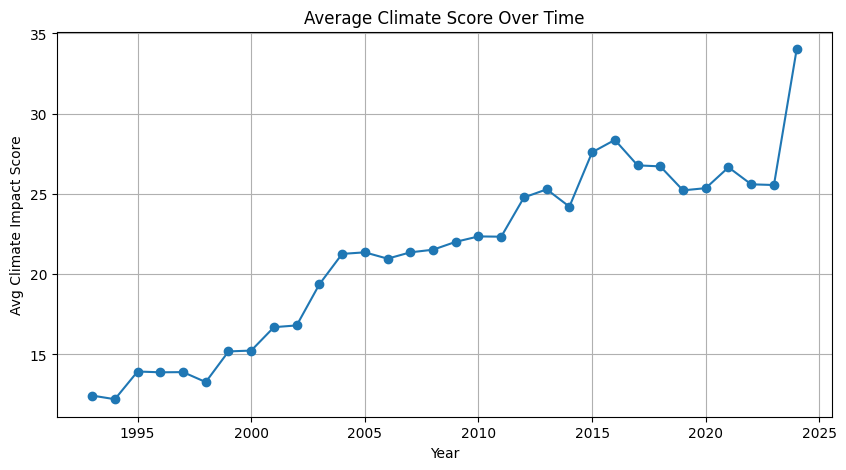

In [164]:
# Climate Score Over Time / Countries
# Trend over years (global avg)
trend = df_combined.groupby('year')['climate_score'].mean()

plt.figure(figsize=(10, 5))
trend.plot(marker='o')
plt.title("Average Climate Score Over Time")
plt.ylabel("Avg Climate Impact Score")
plt.xlabel("Year")
plt.grid(True)
plt.show()


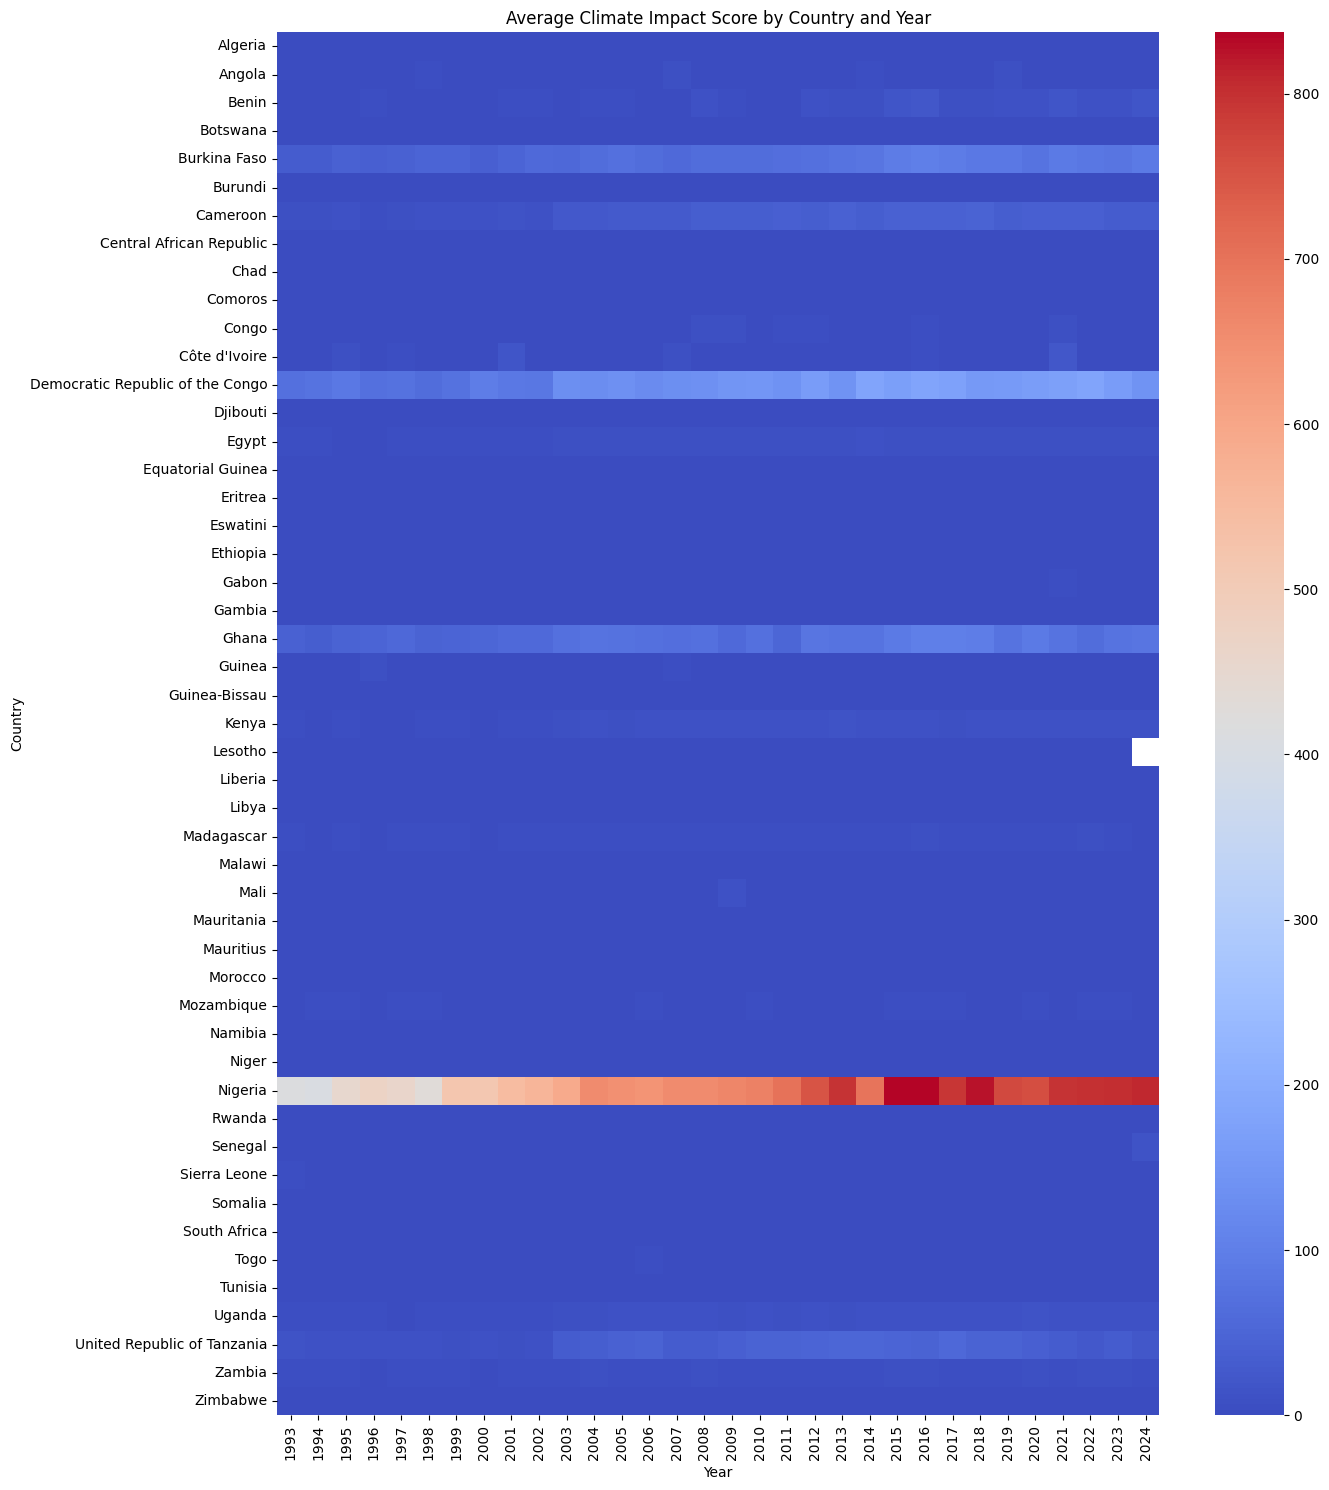

In [165]:
# Climate Score Over Time / Countries
# Heatmap by country-year

avg_scores = df_combined.groupby(['Location', 'year'], as_index=False)['climate_score'].mean()
pivot = avg_scores.pivot(index='Location', columns='year', values='climate_score')

plt.figure(figsize=(14, 15))
sns.heatmap(pivot, cmap='coolwarm', annot=False)
plt.title("Average Climate Impact Score by Country and Year")
plt.xlabel("Year")
plt.ylabel("Country")
plt.tight_layout()
plt.show()

#**Forecast**

In [169]:
# df_combined.to_excel('/content/drive/My Drive/CAN Fellowship/Datasets/Working Folder/shap_climate_scores.xlsx', index=False)

In [3]:
model_df = pd.read_excel('/content/drive/My Drive/CAN Fellowship/Datasets/Working Folder/shap_climate_scores.xlsx')

In [5]:
# SARIMA Forecasting to 2030
from tqdm import tqdm

# Making sure date column is a datetime and setting index
model_df['date'] = pd.to_datetime({
    'year': model_df['year'],
    'month': model_df['month_number'],
    'day': 1
    })
model_df.sort_values(['Location', 'date'], inplace=True)

# Setting forecast horizon to Dec 2030
forecast_end = pd.Timestamp("2030-12-01")
forecast_months = pd.date_range(model_df['date'].max() + pd.DateOffset(months=1), forecast_end, freq='MS')

# Container for forecasts
forecast_list = []

# Variables to forecast
vars = ['Value', 'climate_score']
locations = model_df['Location'].unique()

# Looping through each location and climate variable
for location in tqdm(locations, desc="Forecasting Variables"):
    for var in vars:
        ts = model_df[model_df['Location'] == location].set_index('date')[var].dropna()
        if len(ts) < 24:
            continue  # Skipping if time series is too short to be meaningful

        try:
            model = auto_arima(ts, seasonal=True, m=12, stepwise=True,  max_order=5, suppress_warnings=True)
            print(model.summary())


            forecast = model.predict(n_periods=len(forecast_months))
            df_forecast = pd.DataFrame({
                'Location': location,
                'date': forecast_months,
                var: forecast
            })
            forecast_list.append(df_forecast)

        except Exception as e:
            print(f"Failed for {location} - {var}: {e}")


Forecasting Climate Variables:   0%|          | 0/49 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 a

                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  384
Model:             SARIMAX(0, 1, 2)x(1, 0, [1], 12)   Log Likelihood                 168.512
Date:                              Sun, 13 Jul 2025   AIC                           -327.024
Time:                                      23:16:00   BIC                           -307.284
Sample:                                  01-01-1993   HQIC                          -319.193
                                       - 12-01-2024                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.8429      0.028    -30.340      0.000      -0.897      -0.788
ma.L2         -0.14

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  380
Model:               SARIMAX(1, 1, 1)   Log Likelihood                -168.888
Date:                Sun, 13 Jul 2025   AIC                            345.777
Time:                        23:16:25   BIC                            361.527
Sample:                             0   HQIC                           352.027
                                - 380                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0107      0.004      2.743      0.006       0.003       0.018
ar.L1          0.7485      0.077      9.780      0.000       0.599       0.899
ma.L1         -0.9105      0.043    -20.934      0.0

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  380
Model:                        SARIMAX   Log Likelihood               -1276.231
Date:                Sun, 13 Jul 2025   AIC                           2556.462
Time:                        23:16:30   BIC                           2564.343
Sample:                             0   HQIC                          2559.589
                                - 380                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      1.6763      0.891      1.882      0.060      -0.070       3.422
sigma2        48.3821      1.955     24.752      0.000      44.551      52.213
Ljung-Box (L1) (Q):                   0.81   Jarque-

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  380
Model:             SARIMAX(1, 1, 3)x(2, 0, [1], 12)   Log Likelihood                -570.217
Date:                              Sun, 13 Jul 2025   AIC                           1158.434
Time:                                      23:19:10   BIC                           1193.872
Sample:                                           0   HQIC                          1172.497
                                              - 380                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   8.505e-06   6.71e-05      0.127      0.899      -0.000       0.000
ar.L1          0.96

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  380
Model:               SARIMAX(2, 1, 1)   Log Likelihood               -1399.389
Date:                Sun, 13 Jul 2025   AIC                           2806.779
Time:                        23:20:06   BIC                           2822.529
Sample:                             0   HQIC                          2813.029
                                - 380                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0578      0.076      0.764      0.445      -0.091       0.206
ar.L2          0.1421      0.040      3.584      0.000       0.064       0.220
ma.L1         -0.9669      0.019    -49.882      0.0

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

                                        SARIMAX Results                                        
Dep. Variable:                                       y   No. Observations:                  374
Model:             SARIMAX(1, 0, 1)x(1, 0, [1, 2], 12)   Log Likelihood                 333.842
Date:                                 Sun, 13 Jul 2025   AIC                           -653.684
Time:                                         23:22:19   BIC                           -626.214
Sample:                                              0   HQIC                          -642.777
                                                 - 374                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0002      0.002      0.074      0.941      -0.005       0

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was

                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  374
Model:             SARIMAX(1, 0, 0)x(2, 0, [1], 12)   Log Likelihood                  -8.300
Date:                              Sun, 13 Jul 2025   AIC                             28.600
Time:                                      23:23:13   BIC                             52.145
Sample:                                           0   HQIC                            37.948
                                              - 374                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0012      0.002      0.662      0.508      -0.002       0.005
ar.L1          0.09

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

                                        SARIMAX Results                                        
Dep. Variable:                                       y   No. Observations:                  379
Model:             SARIMAX(1, 1, 1)x(2, 0, [1, 2], 12)   Log Likelihood                -779.914
Date:                                 Sun, 13 Jul 2025   AIC                           1575.828
Time:                                         23:26:00   BIC                           1607.307
Sample:                                              0   HQIC                          1588.322
                                                 - 379                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   4.068e-05   9.88e-05      0.412      0.680      -0.000       0

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was

                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                  379
Model:             SARIMAX(0, 1, 2)x(1, 0, [], 12)   Log Likelihood               -1626.691
Date:                             Sun, 13 Jul 2025   AIC                           3263.382
Time:                                     23:26:35   BIC                           3283.057
Sample:                                          0   HQIC                          3271.191
                                             - 379                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1150      0.061      1.887      0.059      -0.004       0.234
ma.L1         -0.8383      

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                  379
Model:             SARIMAX(5, 1, 1)x(1, 0, [], 12)   Log Likelihood                -103.017
Date:                             Sun, 13 Jul 2025   AIC                            224.034
Time:                                     23:28:48   BIC                            259.448
Sample:                                          0   HQIC                           238.090
                                             - 379                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0015      0.001      2.478      0.013       0.000       0.003
ar.L1          0.7079      

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  379
Model:                        SARIMAX   Log Likelihood                -330.702
Date:                Sun, 13 Jul 2025   AIC                            665.404
Time:                        23:28:53   BIC                            673.279
Sample:                             0   HQIC                           668.530
                                - 379                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0712      0.108      0.659      0.510      -0.141       0.283
sigma2         0.3353      0.013     26.112      0.000       0.310       0.360
Ljung-Box (L1) (Q):                   0.39   Jarque-

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

                                        SARIMAX Results                                        
Dep. Variable:                                       y   No. Observations:                  384
Model:             SARIMAX(2, 1, 1)x(2, 0, [1, 2], 12)   Log Likelihood                -431.517
Date:                                 Sun, 13 Jul 2025   AIC                            879.034
Time:                                         23:31:44   BIC                            910.618
Sample:                                     01-01-1993   HQIC                           891.563
                                          - 12-01-2024                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.1255      0.134     -8.410      0.000      -1.388      -0

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

                                        SARIMAX Results                                        
Dep. Variable:                                       y   No. Observations:                  384
Model:             SARIMAX(0, 1, 1)x(0, 0, [1, 2], 12)   Log Likelihood               -1454.335
Date:                                 Sun, 13 Jul 2025   AIC                           2918.671
Time:                                         23:32:06   BIC                           2938.411
Sample:                                     01-01-1993   HQIC                          2926.501
                                          - 12-01-2024                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0688      0.042      1.638      0.101      -0.014       0

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

                                        SARIMAX Results                                        
Dep. Variable:                                       y   No. Observations:                  382
Model:             SARIMAX(5, 1, 1)x(1, 0, [1, 2], 12)   Log Likelihood                 -79.923
Date:                                 Sun, 13 Jul 2025   AIC                            181.846
Time:                                         23:35:08   BIC                            225.216
Sample:                                              0   HQIC                           199.053
                                                 - 382                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   4.641e-05      0.000      0.434      0.664      -0.000       0

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  382
Model:                        SARIMAX   Log Likelihood                -628.908
Date:                Sun, 13 Jul 2025   AIC                           1259.817
Time:                        23:35:09   BIC                           1263.762
Sample:                             0   HQIC                          1261.382
                                - 382                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         1.5759      0.009    182.662      0.000       1.559       1.593
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):           1921511.57
Prob(Q):                              0.94   Pr

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                  379
Model:             SARIMAX(1, 1, 3)x(1, 0, [], 12)   Log Likelihood                -143.118
Date:                             Sun, 13 Jul 2025   AIC                            300.237
Time:                                     23:36:21   BIC                            327.781
Sample:                                          0   HQIC                           311.169
                                             - 379                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0159      0.005      3.392      0.001       0.007       0.025
ar.L1          0.5903      

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  379
Model:               SARIMAX(0, 0, 1)   Log Likelihood                -687.162
Date:                Sun, 13 Jul 2025   AIC                           1378.324
Time:                        23:36:24   BIC                           1386.199
Sample:                             0   HQIC                          1381.449
                                - 379                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.3483      0.010     34.273      0.000       0.328       0.368
sigma2         2.1989      0.024     91.127      0.000       2.152       2.246
Ljung-Box (L1) (Q):                   0.01   Jarque-

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  384
Model:             SARIMAX(1, 1, 1)x(1, 0, 1, 12)   Log Likelihood                 -85.451
Date:                            Sun, 13 Jul 2025   AIC                            182.902
Time:                                    23:38:20   BIC                            206.590
Sample:                                01-01-1993   HQIC                           192.298
                                     - 12-01-2024                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   6.043e-05      0.000      0.484      0.628      -0.000       0.000
ar.L1          0.6284      0.061   

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  384
Model:                        SARIMAX   Log Likelihood               -1417.068
Date:                Sun, 13 Jul 2025   AIC                           2838.135
Time:                        23:38:25   BIC                           2846.037
Sample:                    01-01-1993   HQIC                          2841.269
                         - 12-01-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      1.5729      1.611      0.976      0.329      -1.585       4.731
sigma2        93.9426      3.801     24.712      0.000      86.492     101.393
Ljung-Box (L1) (Q):                   0.27   Jarque-

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  384
Model:             SARIMAX(0, 1, 4)x(2, 0, [1], 12)   Log Likelihood                -352.288
Date:                              Sun, 13 Jul 2025   AIC                            722.576
Time:                                      23:43:10   BIC                            758.108
Sample:                                  01-01-1993   HQIC                           736.671
                                       - 12-01-2024                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0005      0.002      0.315      0.753      -0.003       0.004
ma.L1         -0.34

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  384
Model:                        SARIMAX   Log Likelihood               -1651.428
Date:                Sun, 13 Jul 2025   AIC                           3306.857
Time:                        23:43:18   BIC                           3314.758
Sample:                    01-01-1993   HQIC                          3309.991
                         - 12-01-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      2.2031      3.013      0.731      0.465      -3.702       8.108
sigma2       318.4014     10.098     31.532      0.000     298.610     338.193
Ljung-Box (L1) (Q):                   0.08   Jarque-

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

                                        SARIMAX Results                                        
Dep. Variable:                                       y   No. Observations:                  384
Model:             SARIMAX(0, 1, 0)x(1, 0, [1, 2], 12)   Log Likelihood                -639.013
Date:                                 Sun, 13 Jul 2025   AIC                           1286.026
Time:                                         23:46:13   BIC                           1301.819
Sample:                                     01-01-1993   HQIC                          1292.291
                                          - 12-01-2024                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12       0.9801      0.003    290.537      0.000       0.973       0

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  384
Model:               SARIMAX(0, 1, 1)   Log Likelihood               -1853.261
Date:                Sun, 13 Jul 2025   AIC                           3710.523
Time:                        23:46:25   BIC                           3718.419
Sample:                    01-01-1993   HQIC                          3713.655
                         - 12-01-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.8940      0.023    -39.242      0.000      -0.939      -0.849
sigma2       930.3257     32.022     29.053      0.000     867.564     993.087
Ljung-Box (L1) (Q):                   0.39   Jarque-

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  376
Model:             SARIMAX(2, 0, 3)x(2, 0, [1], 12)   Log Likelihood                  53.211
Date:                              Sun, 13 Jul 2025   AIC                            -86.421
Time:                                      23:50:41   BIC                            -47.125
Sample:                                           0   HQIC                           -70.822
                                              - 376                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0017      0.001      1.524      0.127      -0.000       0.004
ar.L1         -0.14

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  376
Model:                        SARIMAX   Log Likelihood                 320.619
Date:                Sun, 13 Jul 2025   AIC                           -639.237
Time:                        23:50:44   BIC                           -635.307
Sample:                             0   HQIC                          -637.677
                                - 376                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0106   5.67e-05    187.750      0.000       0.011       0.011
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):           2179781.50
Prob(Q):                              0.96   Pr

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  380
Model:             SARIMAX(3, 1, 1)x(1, 0, 1, 12)   Log Likelihood                -205.230
Date:                            Sun, 13 Jul 2025   AIC                            424.461
Time:                                    23:56:19   BIC                            452.024
Sample:                                         0   HQIC                           435.399
                                            - 380                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3873      0.093      4.152      0.000       0.204       0.570
ar.L2         -0.0574      0.073   

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  380
Model:             SARIMAX(0, 1, 2)x(1, 0, 2, 12)   Log Likelihood                -708.535
Date:                            Mon, 14 Jul 2025   AIC                           1431.070
Time:                                    00:00:11   BIC                           1458.633
Sample:                                         0   HQIC                          1442.008
                                            - 380                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0003      0.001      0.379      0.705      -0.001       0.002
ma.L1         -0.8176      0.044   

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

                                        SARIMAX Results                                        
Dep. Variable:                                       y   No. Observations:                  384
Model:             SARIMAX(1, 1, 1)x(1, 0, [1, 2], 12)   Log Likelihood                  83.866
Date:                                 Mon, 14 Jul 2025   AIC                           -155.731
Time:                                         00:10:15   BIC                           -132.043
Sample:                                     01-01-1993   HQIC                          -146.335
                                          - 12-01-2024                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1042      0.076      1.369      0.171      -0.045       0

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                  383
Model:             SARIMAX(2, 1, 2)x(1, 0, [], 12)   Log Likelihood                 153.592
Date:                             Mon, 14 Jul 2025   AIC                           -293.185
Time:                                     00:11:24   BIC                           -265.567
Sample:                                          0   HQIC                          -282.228
                                             - 383                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0001      0.000      0.432      0.665      -0.000       0.001
ar.L1         -0.4616      

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was

                                SARIMAX Results                                 
Dep. Variable:                        y   No. Observations:                  383
Model:             SARIMAX(1, 0, 0, 12)   Log Likelihood                -674.725
Date:                  Mon, 14 Jul 2025   AIC                           1355.449
Time:                          00:11:43   BIC                           1367.294
Sample:                               0   HQIC                          1360.148
                                  - 383                                         
Covariance Type:                    opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.3435      0.172      1.997      0.046       0.006       0.681
ar.S.L12       0.1049      0.049      2.151      0.031       0.009       0.201
sigma2         1.9840      0.085    

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pmdarima/arima/auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1431: RuntimeWarning: invalid value encountered in divide
  test_statistic = numer_squared_sum / denom_squared_sum
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:702: RuntimeWarning: invalid value encountered in divide
  acf = avf[: nlags + 1] / avf[0]
/usr/local/lib/python3.11/dist-packages/sklearn/utils/

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  373
Model:                        SARIMAX   Log Likelihood                3951.557
Date:                Mon, 14 Jul 2025   AIC                          -7901.114
Time:                        00:11:44   BIC                          -7897.193
Sample:                    01-01-1993   HQIC                         -7899.557
                         - 01-01-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2          1e-10   1.03e-10      0.975      0.330   -1.01e-10    3.01e-10
Ljung-Box (L1) (Q):                    nan   Jarque-Bera (JB):                  nan
Prob(Q):                               nan   Pr

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                  384
Model:             SARIMAX(5, 1, 2)x(2, 0, [], 12)   Log Likelihood                  97.328
Date:                             Mon, 14 Jul 2025   AIC                           -172.657
Time:                                     00:18:15   BIC                           -129.229
Sample:                                 01-01-1993   HQIC                          -155.430
                                      - 12-01-2024                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   4.282e-05      0.000      0.134      0.894      -0.001       0.001
ar.L1         -0.6932      

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  384
Model:                        SARIMAX   Log Likelihood                -648.622
Date:                Mon, 14 Jul 2025   AIC                           1301.244
Time:                        00:18:24   BIC                           1309.145
Sample:                    01-01-1993   HQIC                          1304.378
                         - 12-01-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.2786      0.145      1.922      0.055      -0.005       0.563
sigma2         1.7166      0.051     33.741      0.000       1.617       1.816
Ljung-Box (L1) (Q):                   0.75   Jarque-

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  382
Model:             SARIMAX(1, 1, 1)x(2, 0, 1, 12)   Log Likelihood                  15.807
Date:                            Mon, 14 Jul 2025   AIC                            -19.614
Time:                                    00:22:46   BIC                              4.043
Sample:                                         0   HQIC                           -10.228
                                            - 382                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3873      0.054      7.146      0.000       0.281       0.494
ma.L1         -0.9674      0.024   

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  382
Model:                        SARIMAX   Log Likelihood                -905.158
Date:                Mon, 14 Jul 2025   AIC                           1812.316
Time:                        00:22:59   BIC                           1816.261
Sample:                             0   HQIC                          1813.881
                                - 382                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         6.6937      0.042    161.159      0.000       6.612       6.775
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):           1160428.62
Prob(Q):                              0.93   Pr

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  379
Model:             SARIMAX(2, 1, 2)x(2, 0, 2, 12)   Log Likelihood                -123.695
Date:                            Mon, 14 Jul 2025   AIC                            265.389
Time:                                    00:25:57   BIC                            300.803
Sample:                                         0   HQIC                           279.445
                                            - 379                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.6847      0.083     20.232      0.000       1.522       1.848
ar.L2         -0.7465      0.072   

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

                                        SARIMAX Results                                        
Dep. Variable:                                       y   No. Observations:                  383
Model:             SARIMAX(0, 1, 0)x(2, 0, [1, 2], 12)   Log Likelihood                -699.565
Date:                                 Mon, 14 Jul 2025   AIC                           1409.129
Time:                                         00:27:14   BIC                           1428.857
Sample:                                     01-01-1993   HQIC                          1416.956
                                          - 11-01-2024                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12       0.8022      0.074     10.838      0.000       0.657       0

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  383
Model:               SARIMAX(0, 1, 1)   Log Likelihood               -1674.206
Date:                Mon, 14 Jul 2025   AIC                           3352.413
Time:                        00:27:27   BIC                           3360.303
Sample:                    01-01-1993   HQIC                          3355.543
                         - 11-01-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.8867      0.023    -39.277      0.000      -0.931      -0.842
sigma2       373.7414     18.357     20.360      0.000     337.763     409.720
Ljung-Box (L1) (Q):                   0.43   Jarque-

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  381
Model:             SARIMAX(1, 1, 1)x(2, 0, 1, 12)   Log Likelihood                -415.694
Date:                            Mon, 14 Jul 2025   AIC                            845.388
Time:                                    00:29:04   BIC                            872.969
Sample:                                         0   HQIC                           856.332
                                            - 381                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0002      0.002     -0.092      0.926      -0.004       0.003
ar.L1         -0.3924      0.160   

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  381
Model:                        SARIMAX   Log Likelihood               -1202.061
Date:                Mon, 14 Jul 2025   AIC                           2408.123
Time:                        00:29:11   BIC                           2416.009
Sample:                             0   HQIC                          2411.252
                                - 381                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.4567      1.486      0.307      0.759      -2.456       3.369
sigma2        32.2061      1.205     26.737      0.000      29.845      34.567
Ljung-Box (L1) (Q):                   0.02   Jarque-

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

                                        SARIMAX Results                                        
Dep. Variable:                                       y   No. Observations:                  378
Model:             SARIMAX(1, 1, 1)x(2, 0, [1, 2], 12)   Log Likelihood                  -2.278
Date:                                 Mon, 14 Jul 2025   AIC                             18.557
Time:                                         00:32:12   BIC                             46.082
Sample:                                              0   HQIC                            29.482
                                                 - 378                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4326      0.047      9.134      0.000       0.340       0

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  384
Model:             SARIMAX(2, 1, 2)x(1, 0, [1], 12)   Log Likelihood                -173.066
Date:                              Mon, 14 Jul 2025   AIC                            360.132
Time:                                      00:35:47   BIC                            387.768
Sample:                                  01-01-1993   HQIC                           371.095
                                       - 12-01-2024                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.5550      0.065     24.083      0.000       1.428       1.682
ar.L2         -0.60

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  384
Model:             SARIMAX(0, 1, 2)x(1, 0, 2, 12)   Log Likelihood               -1063.799
Date:                            Mon, 14 Jul 2025   AIC                           2141.597
Time:                                    00:37:10   BIC                           2169.233
Sample:                                01-01-1993   HQIC                          2152.560
                                     - 12-01-2024                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0006      0.001      0.461      0.645      -0.002       0.003
ma.L1         -0.7165      0.045   

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pmdarima/arima/auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1431: RuntimeWarning: invalid value encountered in divide
  test_statistic = numer_squared_sum / denom_squared_sum
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:702: RuntimeWarning: invalid value encountered in divide
  acf = avf[: nlags + 1] / avf[0]
/usr/local/lib/python3.11/dist-packages/sklearn/utils/

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  372
Model:                        SARIMAX   Log Likelihood                3940.963
Date:                Mon, 14 Jul 2025   AIC                          -7879.926
Time:                        00:37:10   BIC                          -7876.007
Sample:                    01-01-1993   HQIC                         -7878.370
                         - 12-01-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2          1e-10   1.03e-10      0.973      0.330   -1.01e-10    3.01e-10
Ljung-Box (L1) (Q):                    nan   Jarque-Bera (JB):                  nan
Prob(Q):                               nan   Pr

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  384
Model:             SARIMAX(0, 1, 4)x(1, 0, [1], 12)   Log Likelihood                 -83.049
Date:                              Mon, 14 Jul 2025   AIC                            182.099
Time:                                      00:42:22   BIC                            213.683
Sample:                                  01-01-1993   HQIC                           194.628
                                       - 12-01-2024                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   5.668e-05      0.000      0.280      0.779      -0.000       0.000
ma.L1         -0.33

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                  382
Model:             SARIMAX(5, 1, 1)x(2, 0, [], 12)   Log Likelihood                  27.438
Date:                             Mon, 14 Jul 2025   AIC                            -34.875
Time:                                     00:44:27   BIC                              4.553
Sample:                                          0   HQIC                           -19.232
                                             - 382                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0007      0.000      2.533      0.011       0.000       0.001
ar.L1          0.3137      

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  382
Model:               SARIMAX(0, 0, 2)   Log Likelihood                -381.433
Date:                Mon, 14 Jul 2025   AIC                            770.866
Time:                        00:44:39   BIC                            786.648
Sample:                             0   HQIC                           777.127
                                - 382                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1490      0.093      1.593      0.111      -0.034       0.332
ma.L1          0.0034      0.089      0.038      0.970      -0.172       0.178
ma.L2          0.1945      0.020      9.943      0.0

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  384
Model:             SARIMAX(1, 1, 1)x(1, 0, 1, 12)   Log Likelihood                 -52.252
Date:                            Mon, 14 Jul 2025   AIC                            116.504
Time:                                    00:46:39   BIC                            140.192
Sample:                                01-01-1993   HQIC                           125.900
                                     - 12-01-2024                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   9.874e-05      0.000      0.853      0.393      -0.000       0.000
ar.L1          0.6446      0.075   

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  384
Model:               SARIMAX(2, 1, 1)   Log Likelihood                -916.926
Date:                Mon, 14 Jul 2025   AIC                           1841.853
Time:                        00:47:55   BIC                           1857.645
Sample:                    01-01-1993   HQIC                          1848.117
                         - 12-01-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0413      0.056      0.736      0.462      -0.069       0.151
ar.L2          0.0744      0.053      1.395      0.163      -0.030       0.179
ma.L1         -0.9731      0.017    -58.393      0.0

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

                                        SARIMAX Results                                        
Dep. Variable:                                       y   No. Observations:                  378
Model:             SARIMAX(1, 1, 1)x(1, 0, [1, 2], 12)   Log Likelihood                  -2.950
Date:                                 Mon, 14 Jul 2025   AIC                             17.900
Time:                                         00:50:41   BIC                             41.493
Sample:                                              0   HQIC                            27.264
                                                 - 378                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3418      0.045      7.551      0.000       0.253       0

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was

                                SARIMAX Results                                 
Dep. Variable:                        y   No. Observations:                  378
Model:             SARIMAX(2, 0, 0, 12)   Log Likelihood                -787.092
Date:                  Mon, 14 Jul 2025   AIC                           1582.185
Time:                          00:51:04   BIC                           1597.925
Sample:                               0   HQIC                          1588.432
                                  - 378                                         
Covariance Type:                    opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.4717      0.203      2.326      0.020       0.074       0.869
ar.S.L12       0.2192      0.028      7.919      0.000       0.165       0.273
ar.S.L24       0.1689      0.035    

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  379
Model:             SARIMAX(1, 1, 0)x(2, 0, 0, 12)   Log Likelihood                -435.238
Date:                            Mon, 14 Jul 2025   AIC                            878.476
Time:                                    00:51:33   BIC                            894.216
Sample:                                         0   HQIC                           884.723
                                            - 379                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0908      0.065     -1.400      0.161      -0.218       0.036
ar.S.L12       0.3270      0.026   

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  379
Model:                        SARIMAX   Log Likelihood               -1274.490
Date:                Mon, 14 Jul 2025   AIC                           2550.981
Time:                        00:51:35   BIC                           2554.918
Sample:                             0   HQIC                          2552.543
                                - 379                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2        48.7968      0.262    186.501      0.000      48.284      49.310
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):           2105590.69
Prob(Q):                              0.94   Pr

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  379
Model:             SARIMAX(2, 1, 1)x(1, 0, 1, 12)   Log Likelihood                   4.064
Date:                            Mon, 14 Jul 2025   AIC                              3.872
Time:                                    00:55:36   BIC                             27.481
Sample:                                         0   HQIC                            13.242
                                            - 379                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4605      0.051      9.096      0.000       0.361       0.560
ar.L2         -0.0967      0.075   

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  379
Model:                        SARIMAX   Log Likelihood                -584.120
Date:                Mon, 14 Jul 2025   AIC                           1170.239
Time:                        00:55:38   BIC                           1174.177
Sample:                             0   HQIC                          1171.802
                                - 379                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         1.2770      0.007    189.250      0.000       1.264       1.290
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):           2232657.25
Prob(Q):                              0.96   Pr

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

                                        SARIMAX Results                                        
Dep. Variable:                                       y   No. Observations:                  375
Model:             SARIMAX(4, 1, 1)x(1, 0, [1, 2], 12)   Log Likelihood                 236.958
Date:                                 Mon, 14 Jul 2025   AIC                           -455.916
Time:                                         01:02:11   BIC                           -420.598
Sample:                                     01-01-1993   HQIC                          -441.893
                                          - 03-01-2024                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4442      0.029     15.360      0.000       0.388       0

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                  384
Model:             SARIMAX(0, 1, 2)x(1, 0, [], 12)   Log Likelihood                 106.954
Date:                             Mon, 14 Jul 2025   AIC                           -205.908
Time:                                     01:03:45   BIC                           -190.116
Sample:                                 01-01-1993   HQIC                          -199.644
                                      - 12-01-2024                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.8158      0.030    -27.164      0.000      -0.875      -0.757
ma.L2         -0.1571      

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  381
Model:             SARIMAX(1, 1, 1)x(1, 0, 1, 12)   Log Likelihood                 -98.744
Date:                            Mon, 14 Jul 2025   AIC                            207.489
Time:                                    01:06:16   BIC                            227.189
Sample:                                         0   HQIC                           215.306
                                            - 381                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7220      0.059     12.208      0.000       0.606       0.838
ma.L1         -0.9834      0.014   

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was

                                        SARIMAX Results                                        
Dep. Variable:                                       y   No. Observations:                  381
Model:             SARIMAX(1, 0, 0)x(2, 0, [1, 2], 12)   Log Likelihood               -1018.151
Date:                                 Mon, 14 Jul 2025   AIC                           2050.302
Time:                                         01:08:22   BIC                           2077.902
Sample:                                              0   HQIC                          2061.253
                                                 - 381                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.2432      0.209      1.164      0.244      -0.166       0

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pmdarima/arima/auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1431: RuntimeWarning: invalid value encountered in divide
  test_statistic = numer_squared_sum / denom_squared_sum
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:702: RuntimeWarning: invalid value encountered in divide
  acf = avf[: nlags + 1] / avf[0]
/usr/local/lib/python3.11/dist-packages/statsmodels/ts

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  377
Model:               SARIMAX(0, 0, 1)   Log Likelihood                 289.730
Date:                Mon, 14 Jul 2025   AIC                           -573.460
Time:                        01:08:30   BIC                           -561.663
Sample:                             0   HQIC                          -568.778
                                - 377                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0132      0.042      0.313      0.754      -0.070       0.096
ma.L1          0.2005      0.021      9.618      0.000       0.160       0.241
sigma2         0.0126      0.001     13.977      0.0

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

                                        SARIMAX Results                                        
Dep. Variable:                                       y   No. Observations:                  380
Model:             SARIMAX(2, 1, 1)x(2, 0, [1, 2], 12)   Log Likelihood                -447.839
Date:                                 Mon, 14 Jul 2025   AIC                            911.678
Time:                                         01:10:13   BIC                            943.178
Sample:                                              0   HQIC                           924.179
                                                 - 380                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7657      0.058     13.153      0.000       0.652       0

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

                                        SARIMAX Results                                        
Dep. Variable:                                       y   No. Observations:                  384
Model:             SARIMAX(0, 1, 0)x(0, 1, [1, 2], 12)   Log Likelihood               -1261.731
Date:                                 Mon, 14 Jul 2025   AIC                           2529.463
Time:                                         01:10:41   BIC                           2541.211
Sample:                                     01-01-1993   HQIC                          2534.129
                                          - 12-01-2024                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.S.L12      -0.2854      0.018    -15.913      0.000      -0.321      -0

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                  384
Model:             SARIMAX(0, 1, 2)x(1, 0, [], 12)   Log Likelihood               -2164.842
Date:                             Mon, 14 Jul 2025   AIC                           4339.684
Time:                                     01:11:18   BIC                           4359.425
Sample:                                 01-01-1993   HQIC                          4347.515
                                      - 12-01-2024                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.9768      0.319      3.064      0.002       0.352       1.602
ma.L1         -0.6998      

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  382
Model:             SARIMAX(1, 1, 1)x(1, 0, 1, 12)   Log Likelihood                  35.778
Date:                            Mon, 14 Jul 2025   AIC                            -61.556
Time:                                    01:19:20   BIC                            -41.842
Sample:                                         0   HQIC                           -53.734
                                            - 382                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4282      0.034     12.675      0.000       0.362       0.494
ma.L1         -0.9891      0.011   

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  382
Model:                        SARIMAX   Log Likelihood                -602.686
Date:                Mon, 14 Jul 2025   AIC                           1209.373
Time:                        01:19:34   BIC                           1217.263
Sample:                             0   HQIC                          1212.503
                                - 382                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.3037      0.186      1.636      0.102      -0.060       0.668
sigma2         1.3738      0.096     14.312      0.000       1.186       1.562
Ljung-Box (L1) (Q):                   0.54   Jarque-

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  379
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -380.829
Date:                Mon, 14 Jul 2025   AIC                            763.659
Time:                        01:19:51   BIC                            767.594
Sample:                             0   HQIC                           765.221
                                - 379                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.4392      0.009     50.779      0.000       0.422       0.456
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):             10073.18
Prob(Q):                              0.81   Pr

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  379
Model:                        SARIMAX   Log Likelihood               -1174.379
Date:                Mon, 14 Jul 2025   AIC                           2352.759
Time:                        01:20:05   BIC                           2360.634
Sample:                             0   HQIC                          2355.884
                                - 379                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.4195      1.023      0.410      0.682      -1.586       2.425
sigma2        28.7712      0.679     42.390      0.000      27.441      30.102
Ljung-Box (L1) (Q):                   0.01   Jarque-

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  382
Model:             SARIMAX(5, 1, 0)x(2, 0, 0, 12)   Log Likelihood                -263.882
Date:                            Mon, 14 Jul 2025   AIC                            543.763
Time:                                    01:22:43   BIC                            575.306
Sample:                                         0   HQIC                           556.278
                                            - 382                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2370      0.048     -4.970      0.000      -0.330      -0.144
ar.L2         -0.2110      0.056   

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

                                        SARIMAX Results                                        
Dep. Variable:                                       y   No. Observations:                  381
Model:             SARIMAX(0, 1, 0)x(2, 0, [1, 2], 12)   Log Likelihood                -144.327
Date:                                 Mon, 14 Jul 2025   AIC                            298.654
Time:                                         01:23:44   BIC                            318.355
Sample:                                              0   HQIC                           306.471
                                                 - 381                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12       0.3752      0.164      2.285      0.022       0.053       0

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was

                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  381
Model:             SARIMAX(1, 0, 0)x(1, 0, [1], 12)   Log Likelihood                -895.689
Date:                              Mon, 14 Jul 2025   AIC                           1801.378
Time:                                      01:24:02   BIC                           1821.092
Sample:                                           0   HQIC                          1809.200
                                              - 381                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0993      0.103      0.960      0.337      -0.104       0.302
ar.L1          0.11

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                  383
Model:             SARIMAX(0, 0, 1)x(1, 0, [], 12)   Log Likelihood                 567.304
Date:                             Mon, 14 Jul 2025   AIC                          -1128.608
Time:                                     01:25:28   BIC                          -1116.764
Sample:                                          0   HQIC                         -1123.909
                                             - 383                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.0128      0.098      0.131      0.896      -0.179       0.204
ar.S.L12       0.9897      

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  383
Model:               SARIMAX(0, 0, 1)   Log Likelihood                 181.008
Date:                Mon, 14 Jul 2025   AIC                           -356.016
Time:                        01:25:39   BIC                           -344.172
Sample:                             0   HQIC                          -351.318
                                - 383                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0235      0.099      0.238      0.812      -0.170       0.217
ma.L1          0.0942      0.031      3.023      0.003       0.033       0.155
sigma2         0.0228      0.004      5.297      0.0

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

                                        SARIMAX Results                                        
Dep. Variable:                                       y   No. Observations:                  380
Model:             SARIMAX(3, 1, 1)x(1, 0, [1, 2], 12)   Log Likelihood                -371.160
Date:                                 Mon, 14 Jul 2025   AIC                            760.320
Time:                                         01:28:27   BIC                            795.757
Sample:                                              0   HQIC                           774.383
                                                 - 380                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0002      0.003      0.050      0.960      -0.006       0

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  380
Model:                        SARIMAX   Log Likelihood                -945.517
Date:                Mon, 14 Jul 2025   AIC                           1895.034
Time:                        01:28:33   BIC                           1902.915
Sample:                             0   HQIC                          1898.161
                                - 380                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.3553      0.546      0.651      0.515      -0.714       1.425
sigma2         8.4869      0.328     25.906      0.000       7.845       9.129
Ljung-Box (L1) (Q):                   0.09   Jarque-

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

                                        SARIMAX Results                                        
Dep. Variable:                                       y   No. Observations:                  384
Model:             SARIMAX(1, 0, 1)x(1, 0, [1, 2], 12)   Log Likelihood                 263.317
Date:                                 Mon, 14 Jul 2025   AIC                           -512.633
Time:                                         01:31:17   BIC                           -484.979
Sample:                                     01-01-1993   HQIC                          -501.664
                                          - 12-01-2024                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0447      0.279      0.160      0.873      -0.502       0

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  384
Model:             SARIMAX(2, 1, 1)x(1, 0, 1, 12)   Log Likelihood                -262.010
Date:                            Mon, 14 Jul 2025   AIC                            538.021
Time:                                    01:32:41   BIC                            565.657
Sample:                                01-01-1993   HQIC                           548.983
                                     - 12-01-2024                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   8.625e-05      0.000      0.564      0.573      -0.000       0.000
ar.L1          0.7032      0.092   

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

                                        SARIMAX Results                                        
Dep. Variable:                                       y   No. Observations:                  384
Model:             SARIMAX(2, 1, 1)x(1, 0, [1, 2], 12)   Log Likelihood               -1001.611
Date:                                 Mon, 14 Jul 2025   AIC                           2019.223
Time:                                         01:35:01   BIC                           2050.807
Sample:                                     01-01-1993   HQIC                          2031.752
                                          - 12-01-2024                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0002      0.001      0.314      0.753      -0.001       0

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  383
Model:             SARIMAX(2, 1, 1)x(1, 0, 1, 12)   Log Likelihood                -306.612
Date:                            Mon, 14 Jul 2025   AIC                            627.224
Time:                                    01:37:36   BIC                            654.842
Sample:                                         0   HQIC                           638.180
                                            - 383                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0054      0.005      1.168      0.243      -0.004       0.014
ar.L1          0.7428      0.146   

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  383
Model:             SARIMAX(2, 1, 1)x(1, 0, 1, 12)   Log Likelihood               -1438.080
Date:                            Mon, 14 Jul 2025   AIC                           2888.161
Time:                                    01:41:45   BIC                           2911.833
Sample:                                         0   HQIC                          2897.552
                                            - 383                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3057      0.053      5.750      0.000       0.202       0.410
ar.L2          0.2840      0.051   

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  379
Model:             SARIMAX(3, 1, 1)x(1, 0, 1, 12)   Log Likelihood                -120.982
Date:                            Mon, 14 Jul 2025   AIC                            255.965
Time:                                    01:47:17   BIC                            283.509
Sample:                                         0   HQIC                           266.897
                                            - 379                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5207      0.078      6.664      0.000       0.368       0.674
ar.L2         -0.0758      0.076   

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was

                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  379
Model:             SARIMAX(2, 1, 0)x(1, 0, [1], 12)   Log Likelihood               -1018.036
Date:                              Mon, 14 Jul 2025   AIC                           2046.071
Time:                                      01:48:16   BIC                           2065.745
Sample:                                           0   HQIC                          2053.879
                                              - 379                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5898      0.035    -16.666      0.000      -0.659      -0.520
ar.L2         -0.33

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  375
Model:             SARIMAX(1, 1, 1)x(2, 0, 1, 12)   Log Likelihood                 -36.769
Date:                            Mon, 14 Jul 2025   AIC                             85.538
Time:                                    01:52:47   BIC                            109.083
Sample:                                         0   HQIC                            94.886
                                            - 375                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5915      0.047     12.526      0.000       0.499       0.684
ma.L1         -0.9701      0.019   

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  375
Model:             SARIMAX(1, 1, 1)x(1, 0, 1, 12)   Log Likelihood                -308.887
Date:                            Mon, 14 Jul 2025   AIC                            629.774
Time:                                    01:54:32   BIC                            653.320
Sample:                                         0   HQIC                           639.123
                                            - 375                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0003      0.000      1.119      0.263      -0.000       0.001
ar.L1          0.3188      0.046   

In [19]:
# Merging Forecasts Into One Table
# Combining all forecasts
forecast_df = pd.concat(forecast_list, axis=0)

# Pivoting to get each variable as a column
forecast_df = forecast_df.pivot_table(index=['Location', 'date'],
                                      values=vars).reset_index()

# Adding month/year for later use
forecast_df['month'] = forecast_df['date'].dt.month
forecast_df['year'] = forecast_df['date'].dt.year

# Adding back region and country code info
meta_cols = ['Location', 'region', 'country_code']
meta_df = model_df[meta_cols].drop_duplicates()
forecast_df = forecast_df.merge(meta_df, on='Location', how='left')

In [20]:
forecast_df['Value']= np.round(np.clip(forecast_df['Value'], 0, None),0)
forecast_df['climate_score']= np.round(np.clip(forecast_df['climate_score'], 0, None),0)

In [21]:
forecast_df['climate_score'] = forecast_df['climate_score'].fillna(0)

In [26]:
forecast_df['climate_strength'] = forecast_df['climate_score'] / forecast_df['Value']
forecast_df['climate_strength'] = np.round(np.clip(forecast_df['climate_strength'] , 0, 0.99),2)

In [22]:
# Adding Risk Labels
def classify_risk_levels(df, variable, abs_quantiles=[0.33, 0.66]):
    df = df.copy()

    # Absolute Risk Label (based on all forecast months for each location)
    def absolute_risk_label(val, q1, q2):
        if val <= q1:
            return "Low"
        elif val <= q2:
            return "Moderate"
        else:
            return "High"

    risk_labels = []

    for location in df['Location'].unique():
        loc_df = df[df['Location'] == location].copy()
        series = loc_df[variable]

        # Getting country quantile thresholds
        q1 = series.quantile(abs_quantiles[0])
        q2 = series.quantile(abs_quantiles[1])

        # Assigning absolute risk
        loc_df['abs_risk'] = series.apply(lambda x: absolute_risk_label(x, q1, q2))

        # Relative Month Ranking (within each year)
        loc_df['month_rank'] = loc_df.groupby('year')[variable].rank(ascending=False, method='min')

        # Combining both
        loc_df['hybrid_risk_label'] = loc_df.apply(
            lambda row: f"{row['abs_risk']} Risk | Month Rank {int(row['month_rank'])}/12", axis=1
        )

        risk_labels.append(loc_df)

    return pd.concat(risk_labels, axis=0)

forecast_df = classify_risk_levels(forecast_df, variable='climate_score')


In [27]:
forecast_df

,Location,date,Value,climate_score,month,year,region,country_code,abs_risk,month_rank,hybrid_risk_label,climate_strength
0,Algeria,2025-01-01,1.0,0.0,1,2025,North Africa,dz,Low,1.0,Low Risk | Month Rank 1/12,0.00
1,Algeria,2025-02-01,1.0,0.0,2,2025,North Africa,dz,Low,1.0,Low Risk | Month Rank 1/12,0.00
2,Algeria,2025-03-01,2.0,0.0,3,2025,North Africa,dz,Low,1.0,Low Risk | Month Rank 1/12,0.00
3,Algeria,2025-04-01,2.0,0.0,4,2025,North Africa,dz,Low,1.0,Low Risk | Month Rank 1/12,0.00
4,Algeria,2025-05-01,2.0,0.0,5,2025,North Africa,dz,Low,1.0,Low Risk | Month Rank 1/12,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...
3523,Zimbabwe,2030-08-01,3.0,2.0,8,2030,Southern Africa,zw,Low,1.0,Low Risk | Month Rank 1/12,0.67
3524,Zimbabwe,2030-09-01,3.0,2.0,9,2030,Southern Africa,zw,Low,1.0,Low Risk | Month Rank 1/12,0.67
3525,Zimbabwe,2030-10-01,2.0,2.0,10,2030,Southern Africa,zw,Low,1.0,Low Risk | Month Rank 1/12,0.99
3526,Zimbabwe,2030-11-01,2.0,2.0,11,2030,Southern Africa,zw,Low,1.0,Low Risk | Month Rank 1/12,0.99


In [28]:
forecast_df.to_excel('/content/drive/My Drive/CAN Fellowship/Datasets/Working Folder/climate_score_forecast.xlsx', index=False)

In [ ]:
# https://docs.google.com/spreadsheets/d/e/2PACX-1vRJcu5CiDcmDlraI20r9swPHYC-SWcvCXeVnyi2E2Q-Q8ChBuLuLBc1L-vOw3q7SeDA_QW-CSUPdAXV/pub?output=xlsx